# Imports e carregamentos

In [ ]:
import pandas as pd
import numpy as np
import warnings
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import h2o

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import pickle
from h2o.automl import H2OAutoML

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.callbacks import EarlyStopping

warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('data_live_engineer_filtered.csv', encoding='utf-8')

## treinando rede para cada liga

In [ ]:
# Função para criar e aplicar o transformador de colunas
def create_preprocessor(X):
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
        ],
        remainder='passthrough'  # Mantém as características categóricas sem transformação
    )
    return preprocessor.fit(X)



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline

# Lista das ligas únicas no conjunto de dados
leagues = df['league'].unique()

# Dicionário para armazenar histórico de treinamento e avaliação para cada liga
league_histories = {}

# Loop por cada liga para criar, treinar e avaliar um modelo separado
for league in leagues:
    print(f"Treinando modelo para a liga: {league}")
    
    # Filtrando o conjunto de dados para apenas a liga atual
    league_data = df[df['league'] == league]
    
    # Preparando os dados de entrada e saída
    X = league_data.drop(['result', 'league', 'homeTeam', 'awayTeam', 'match_id'], axis=1)
    y = league_data['result']

    preprocessor = create_preprocessor(X)
    X_transformed = preprocessor.transform(X)

    
    model_randomf = RandomForestClassifier(n_estimators=100, random_state=42, 
                                           max_depth=10, min_samples_split=5, 
                                            min_samples_leaf=2)
    # Validação cruzada
    cv_scores = cross_val_score(model_randomf, X_transformed, y, cv=5, scoring='roc_auc')
    print(f"Média AUC para {league}: {cv_scores.mean()}")

    # Treinando e avaliando o modelo
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model_randomf.fit(X_train, y_train)
    train_auc = roc_auc_score(y_train, model_randomf.predict_proba(X_train)[:, 1])
    test_auc = roc_auc_score(y_test, model_randomf.predict_proba(X_test)[:, 1])

    feature_importance = model_randomf.feature_importances_

    # Armazenando a avaliação em um dicionário
    league_histories[league] = {
        'cv_auc_mean': cv_scores.mean(),
        'train_auc': train_auc,
        'test_auc': test_auc,
        'feature_importance': feature_importance
    }

Treinando modelo para a liga: England - Championship
Média AUC para England - Championship: 0.8825264377374351
Treinando modelo para a liga: Italy - Serie B
Média AUC para Italy - Serie B: 0.9248777103442226
Treinando modelo para a liga: Germany - Bundesliga
Média AUC para Germany - Bundesliga: 0.8818767771468952
Treinando modelo para a liga: Brazil - Serie A
Média AUC para Brazil - Serie A: 0.8663921810968004
Treinando modelo para a liga: Mexico - Liga MX
Média AUC para Mexico - Liga MX: 0.9115324959703172
Treinando modelo para a liga: England - Premier League
Média AUC para England - Premier League: 0.8524940135319223
Treinando modelo para a liga: France - Ligue 1
Média AUC para France - Ligue 1: 0.8828556839925596
Treinando modelo para a liga: USA - Major League Soccer
Média AUC para USA - Major League Soccer: 0.8535060137543397
Treinando modelo para a liga: Spain - La Liga 2
Média AUC para Spain - La Liga 2: 0.9247177132655844
Treinando modelo para a liga: Argentina - Superliga
Méd

### Avaliando importancia das features de cada liga

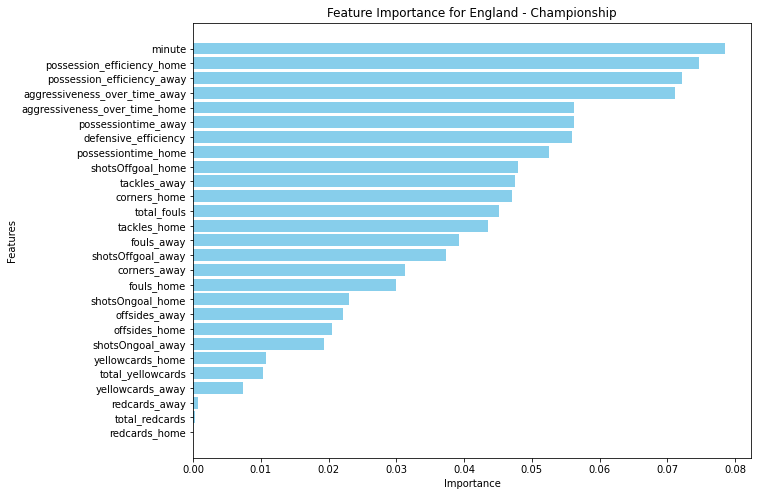

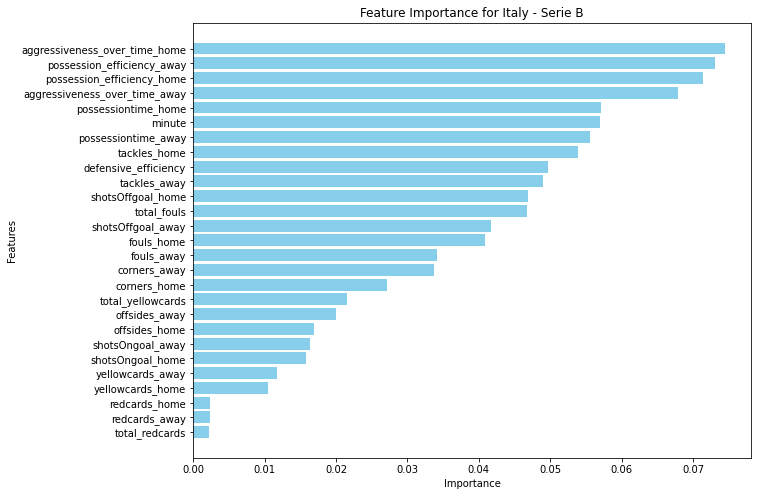

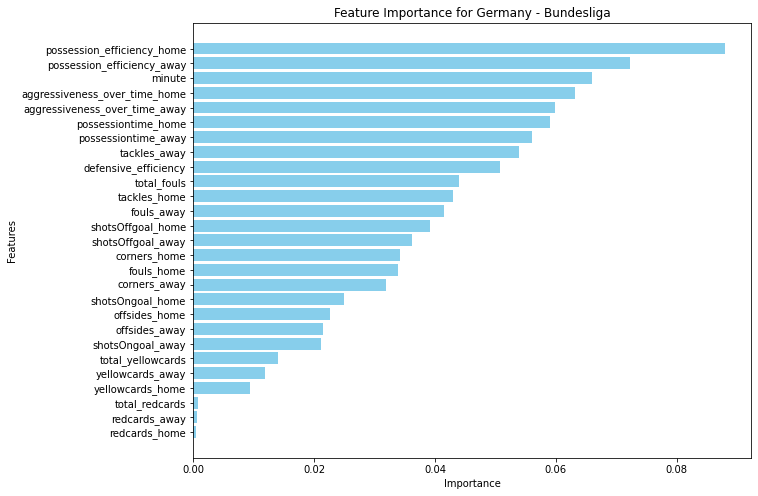

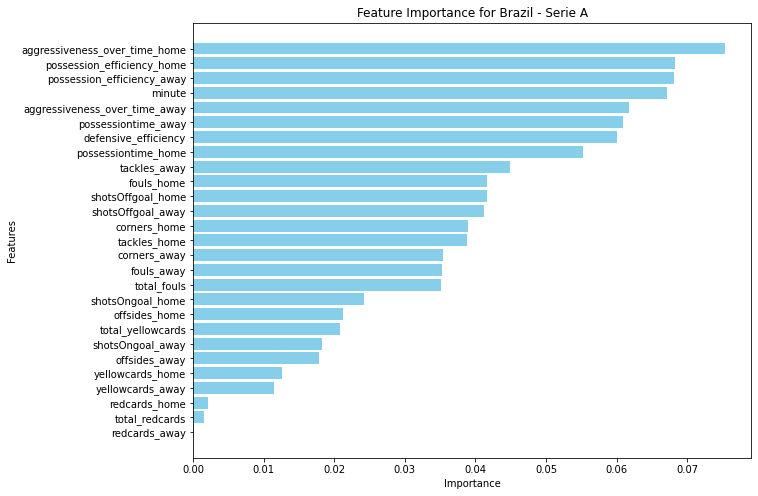

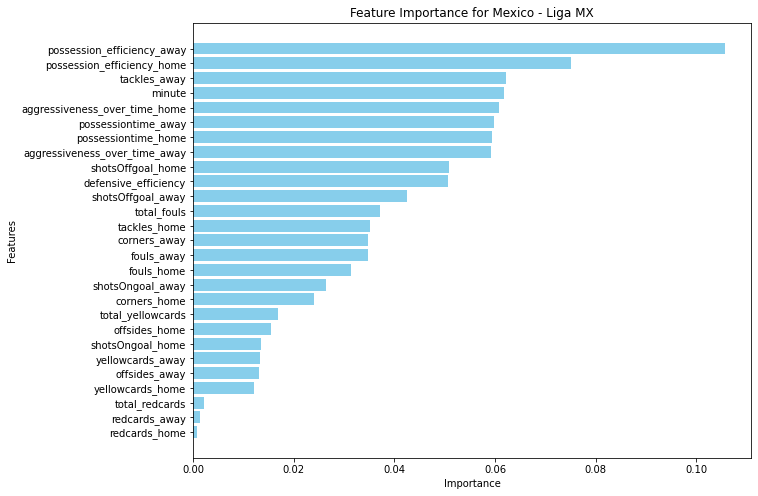

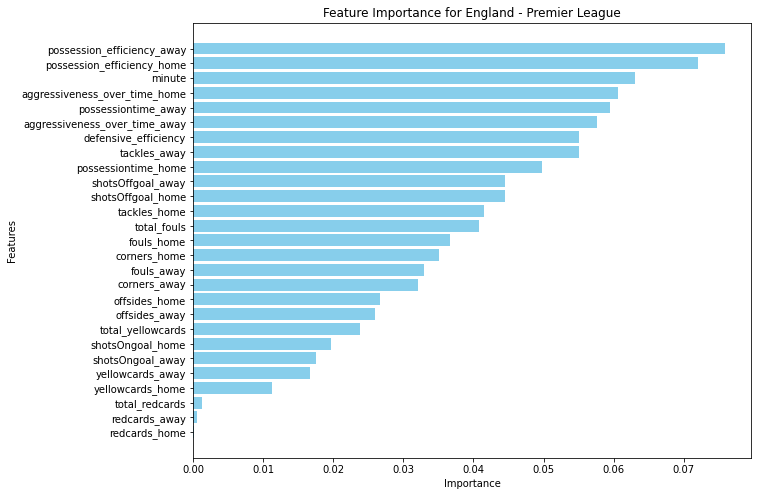

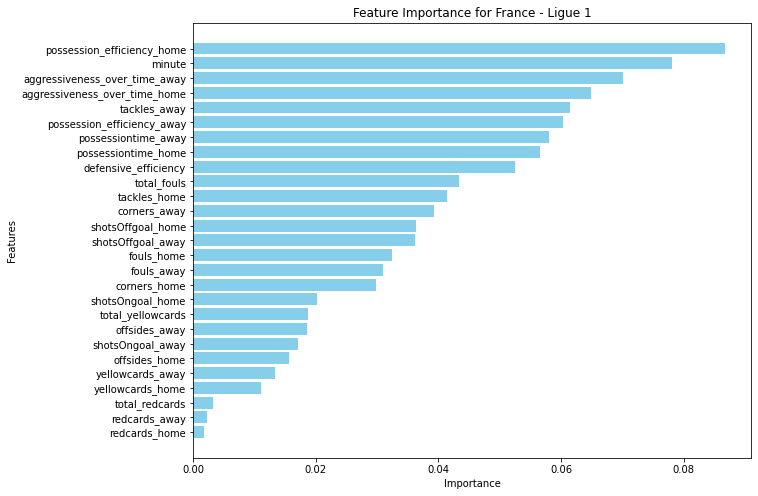

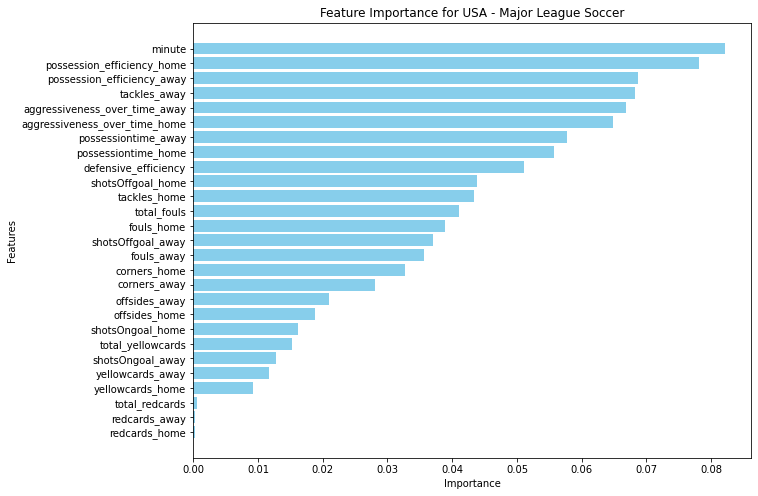

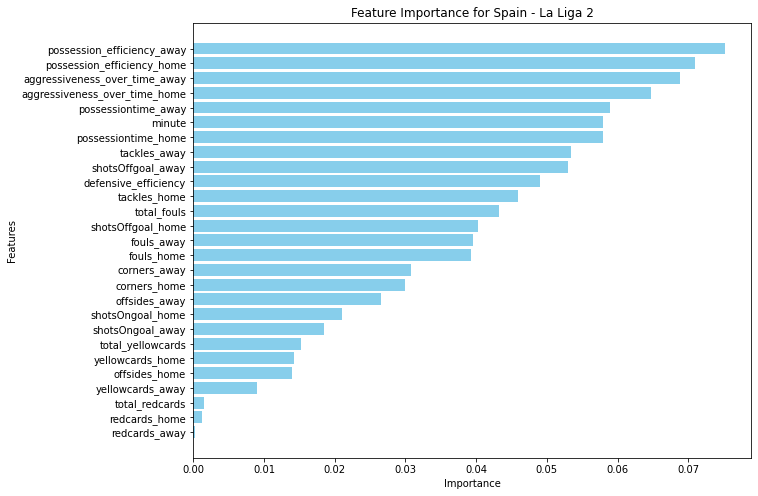

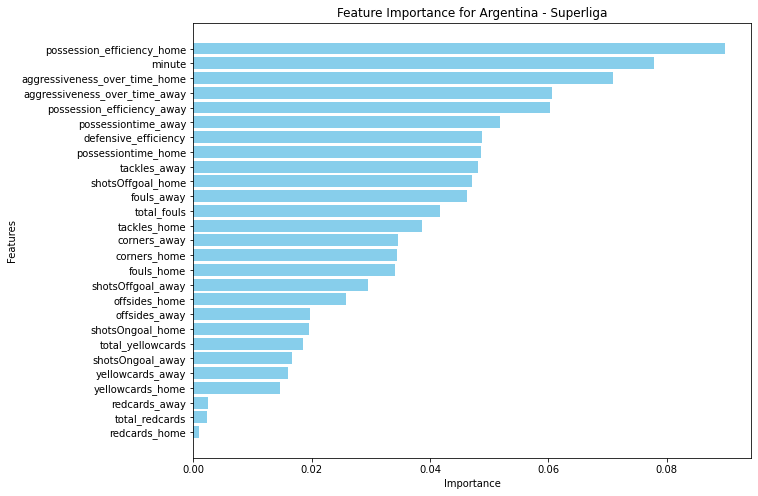

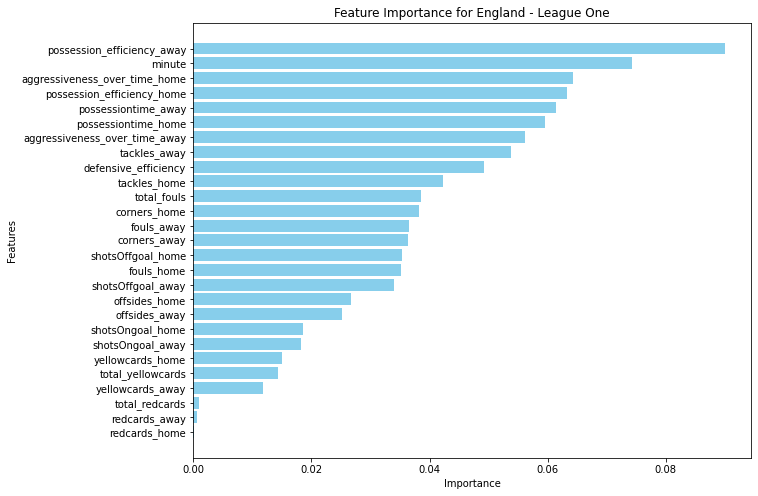

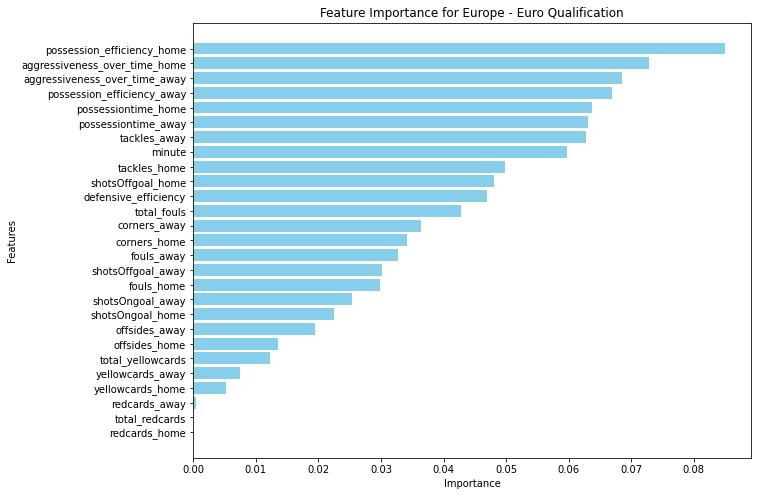

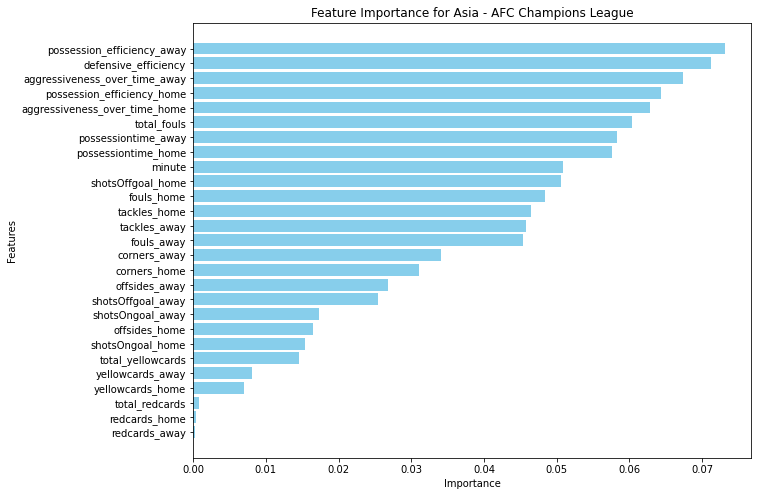

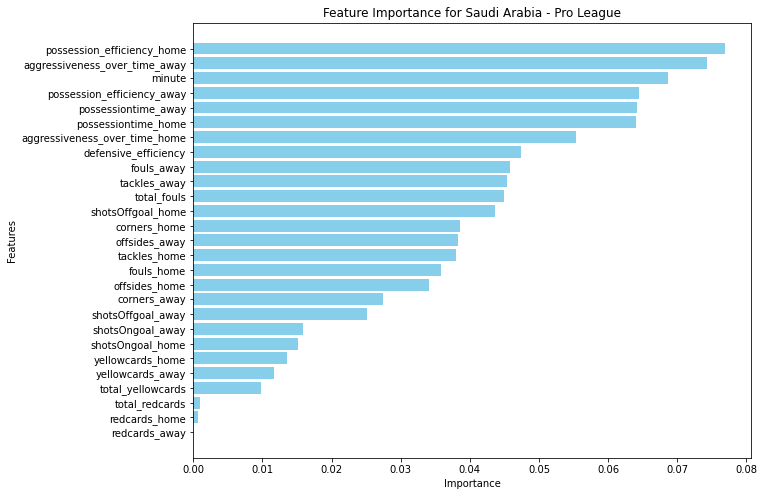

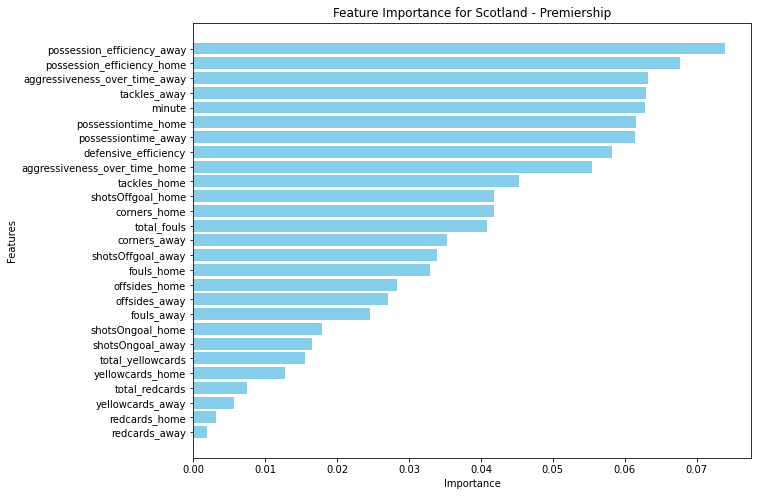

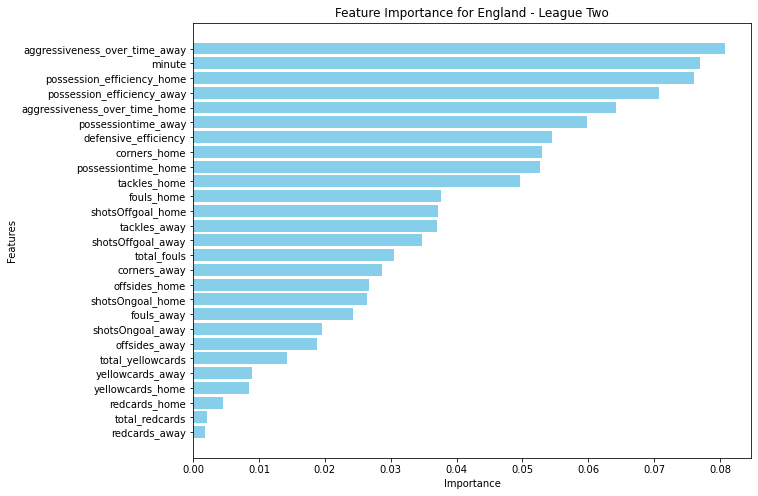

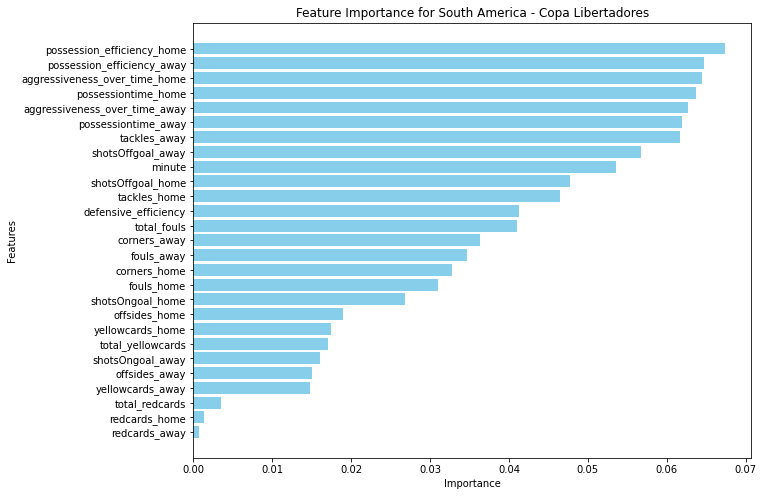

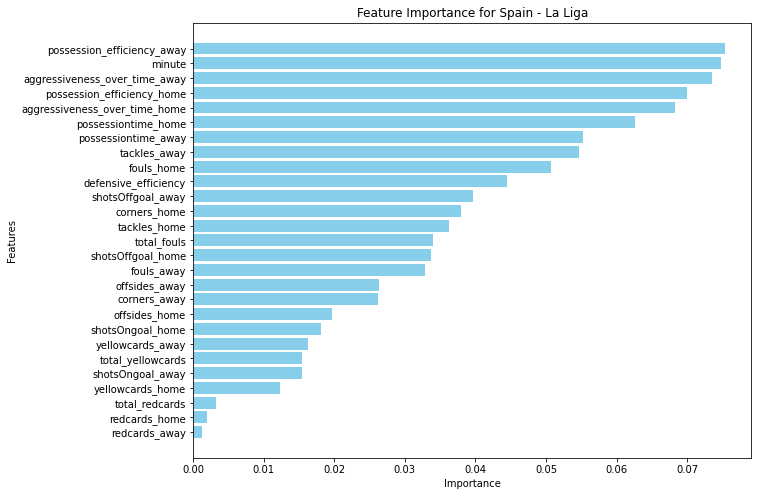

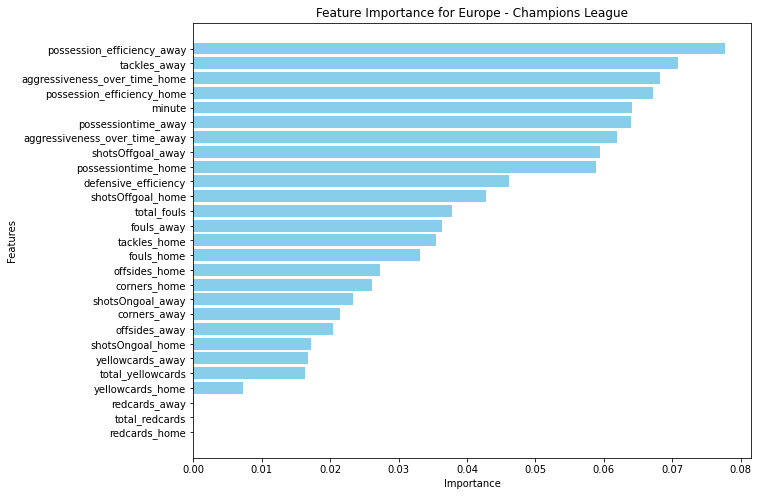

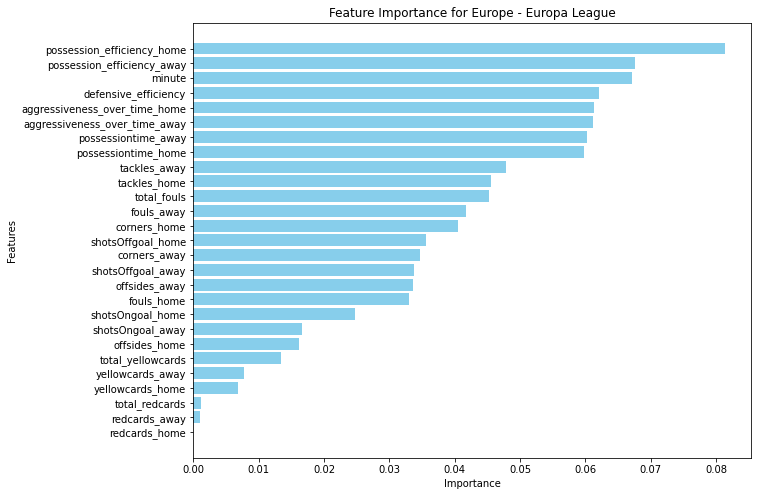

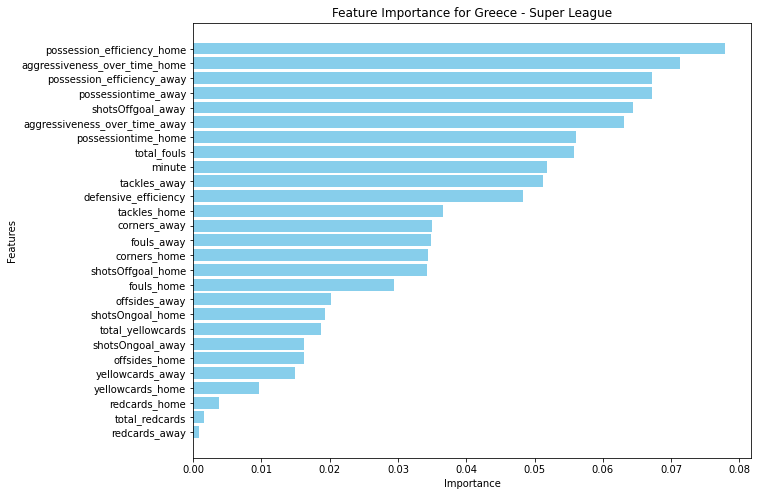

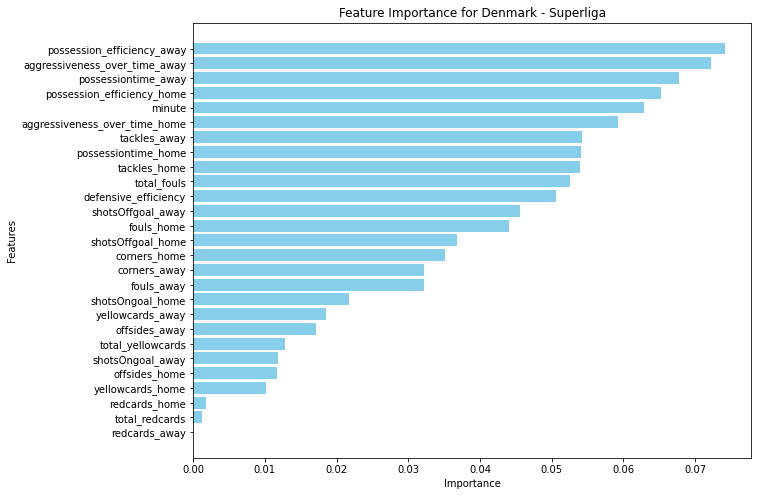

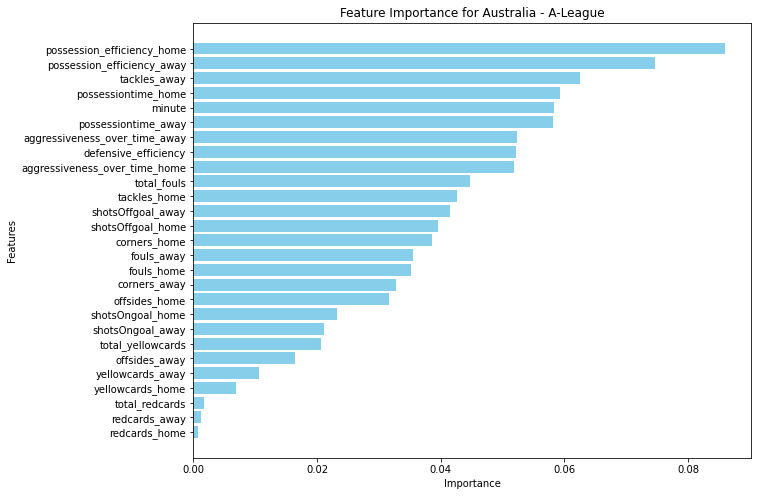

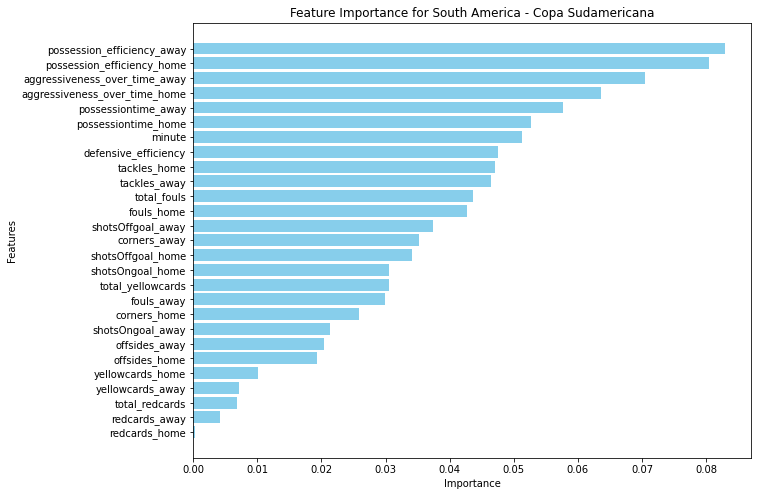

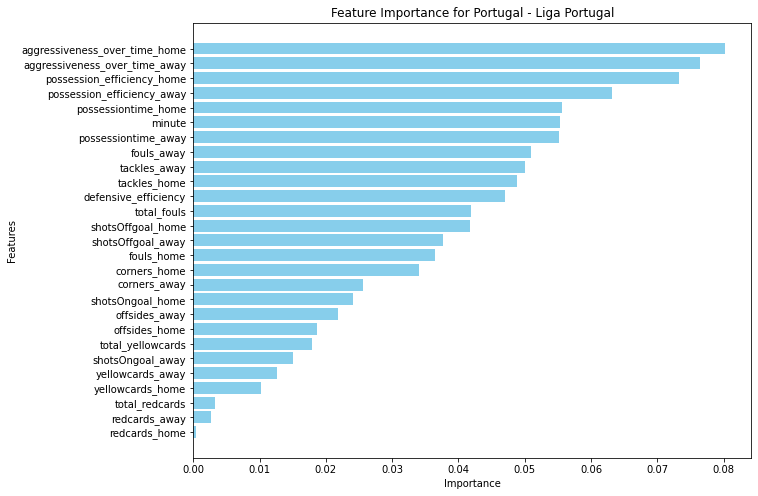

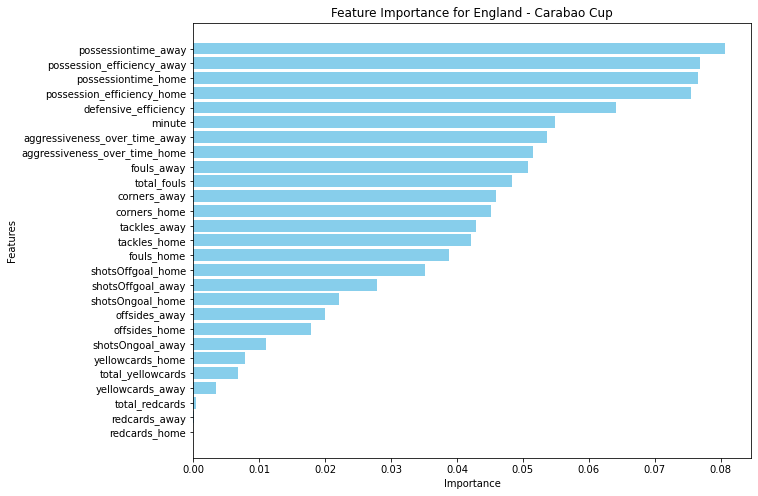

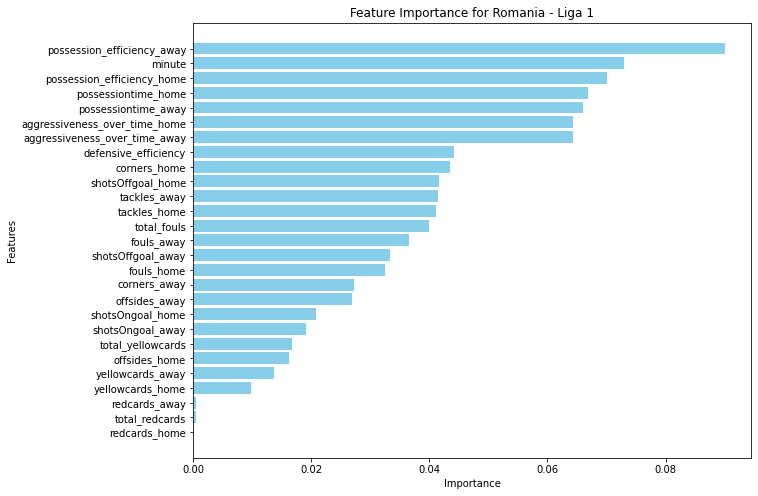

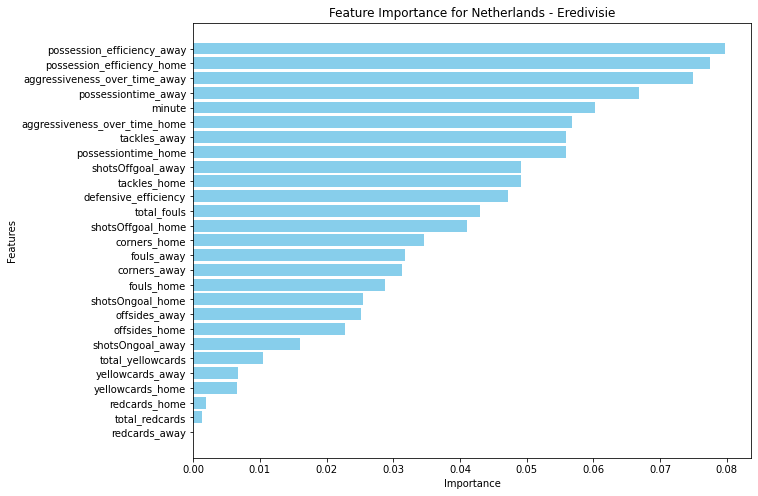

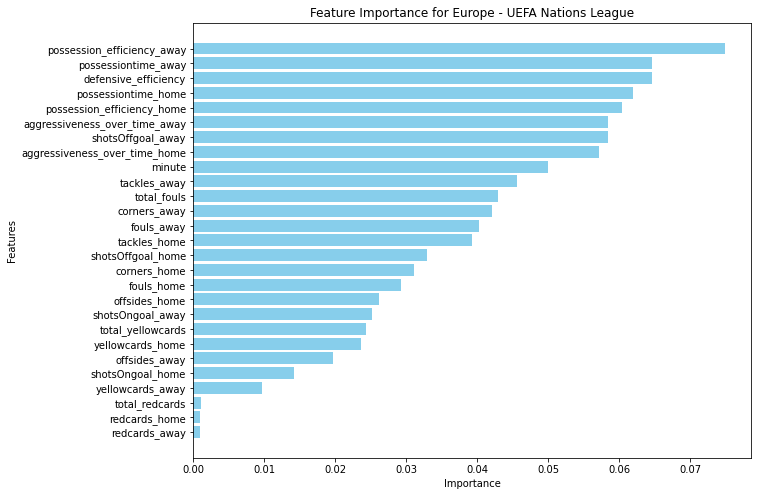

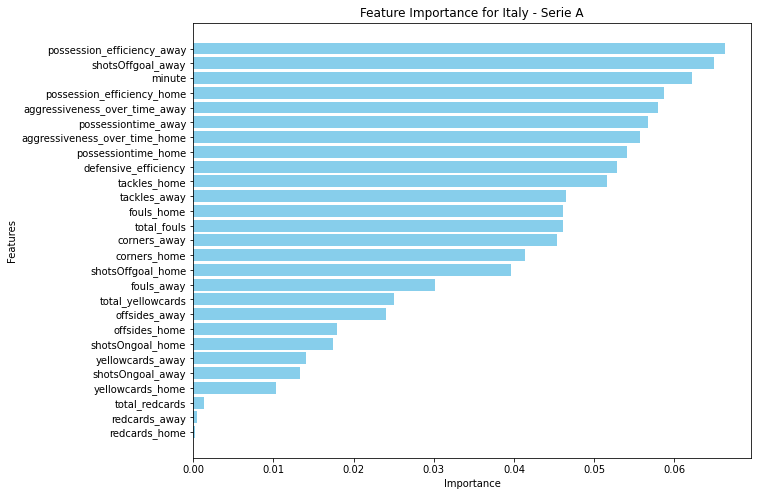

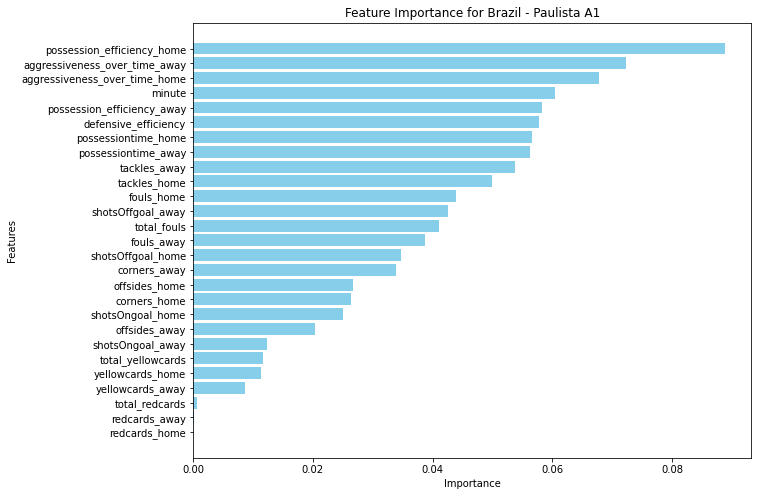

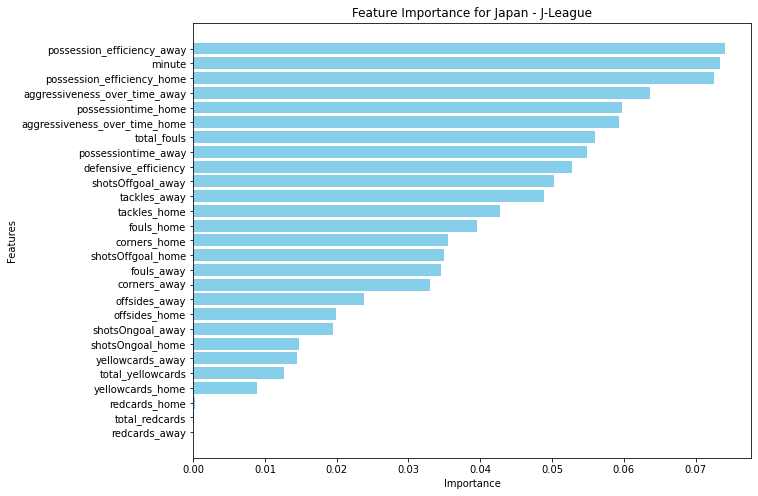

In [ ]:
# Suponha que X_train tenha os nomes das features e league_histories contenha as importâncias
feature_names = X_train.columns

# Loop para criar um gráfico para cada liga
for league, data in league_histories.items():
    # Ordenar as características e suas importâncias
    sorted_idx = np.argsort(data['feature_importance'])
    sorted_feature_names = feature_names[sorted_idx]
    sorted_importances = data['feature_importance'][sorted_idx]

    # Criando o gráfico
    plt.figure(figsize=(10, 8))
    plt.barh(sorted_feature_names, sorted_importances, color='skyblue')
    plt.title(f'Feature Importance for {league}')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.show()


In [ ]:
dataframe_league = pd.DataFrame.from_dict(league_histories, orient='index')
dataframe_league.to_csv('dataframe_leagues_avaliation.csv', index=False, encoding='utf-8')
dataframe_league

,cv_auc_mean,train_auc,test_auc,feature_importance
England - Championship,0.882526,0.961639,0.894844,"[0.07846449317630746, 0.047039112450297425, 0...."
Italy - Serie B,0.924878,0.988153,0.914985,"[0.05697678583585177, 0.02716547506956606, 0.0..."
Germany - Bundesliga,0.881877,0.971801,0.893718,"[0.06593974633194613, 0.03427299656896691, 0.0..."
Brazil - Serie A,0.866392,0.949456,0.854812,"[0.06713153294976561, 0.0389881284847802, 0.03..."
Mexico - Liga MX,0.911532,0.983993,0.900703,"[0.06174618511410279, 0.02397219229302959, 0.0..."
England - Premier League,0.852494,0.941160,0.856625,"[0.06298916931967175, 0.03514118589582654, 0.0..."
France - Ligue 1,0.882856,0.970198,0.854575,"[0.07802024199435718, 0.029892810652392507, 0...."
USA - Major League Soccer,0.853506,0.947884,0.851369,"[0.08207372925958437, 0.032764080709332045, 0...."
Spain - La Liga 2,0.924718,0.987625,0.927849,"[0.05795487245847749, 0.02998985615723257, 0.0..."
Argentina - Superliga,0.887638,0.958241,0.872633,"[0.07793489555083194, 0.0344202983754707, 0.03..."


In [ ]:
# We calculate the mean importance for each feature across all leagues
mean_feature_importances = pd.DataFrame(dataframe_league['feature_importance'].tolist()).mean().tolist()

# First, let's convert the list of feature importances into a DataFrame for easier analysis
df_feature_importances = pd.DataFrame(dataframe_league['feature_importance'].tolist())

# Calculating the variance of each feature's importance across all leagues
feature_variances = df_feature_importances.var()

# Creating a summary DataFrame to hold the variance and correlation data
summary_df = pd.DataFrame({
    'Mean Importance': mean_feature_importances,
    'Variance': feature_variances,
})

# Display the summary dataframe sorted by variance to see which features have the most variability across leagues
summary_df.sort_values('Variance', ascending=False, inplace=True)
summary_df.reset_index(inplace=True)
summary_df.rename(columns={'index': 'Feature'}, inplace=True)
summary_df


,Feature,Mean Importance,Variance
0,6,0.041428,1.163975e-04
1,23,0.073060,9.081105e-05
2,0,0.064236,8.557374e-05
3,22,0.074370,6.963250e-05
4,16,0.052695,6.475178e-05
5,21,0.065408,4.888036e-05
6,20,0.063497,4.769747e-05
7,19,0.052316,4.441554e-05
8,1,0.035416,4.287279e-05
9,12,0.036612,4.095941e-05


In [ ]:
feature_names = df.drop(['result', 'league', 'homeTeam', 'awayTeam', 'match_id'], axis=1).columns

# Mapeando os números para os nomes das características
summary_df['Feature Name'] = summary_df['Feature'].apply(lambda x: feature_names[x])
summary_df

,Feature,Mean Importance,Variance,Feature Name
0,6,0.041428,1.163975e-04,shotsOffgoal_away
1,23,0.073060,9.081105e-05,possession_efficiency_away
2,0,0.064236,8.557374e-05,minute
3,22,0.074370,6.963250e-05,possession_efficiency_home
4,16,0.052695,6.475178e-05,tackles_away
5,21,0.065408,4.888036e-05,aggressiveness_over_time_away
6,20,0.063497,4.769747e-05,aggressiveness_over_time_home
7,19,0.052316,4.441554e-05,defensive_efficiency
8,1,0.035416,4.287279e-05,corners_home
9,12,0.036612,4.095941e-05,fouls_away


In [ ]:
summary_df.sort_values('Mean Importance', ascending=False)

,Feature,Mean Importance,Variance,Feature Name
3,22,0.074370,6.963250e-05,possession_efficiency_home
1,23,0.073060,9.081105e-05,possession_efficiency_away
5,21,0.065408,4.888036e-05,aggressiveness_over_time_away
2,0,0.064236,8.557374e-05,minute
6,20,0.063497,4.769747e-05,aggressiveness_over_time_home
13,17,0.060503,2.972226e-05,possessiontime_away
14,18,0.058292,2.862039e-05,possessiontime_home
4,16,0.052695,6.475178e-05,tackles_away
7,19,0.052316,4.441554e-05,defensive_efficiency
17,15,0.043919,2.727953e-05,tackles_home


- Importância das Características: A tabela fornece um valor de importância média para cada característica, que indica quanto essa característica contribui para a capacidade do modelo de fazer previsões. Quanto maior o valor, mais importante é a característica.

- Variância da Importância: A variância pode nos dizer quão consistente é a importância de uma característica entre os diferentes modelos de liga. Uma variância baixa significa que a característica tem aproximadamente a mesma importância em todas as ligas, enquanto uma variância alta sugere que a importância da característica varia significativamente entre as diferentes ligas.

- Diferenças entre as Ligas: Se algumas características têm uma alta variância na importância, isso pode indicar que as ligas têm dinâmicas diferentes que afetam os resultados dos jogos. Por exemplo, uma característica pode ser muito importante em uma liga, mas menos importante em outra.

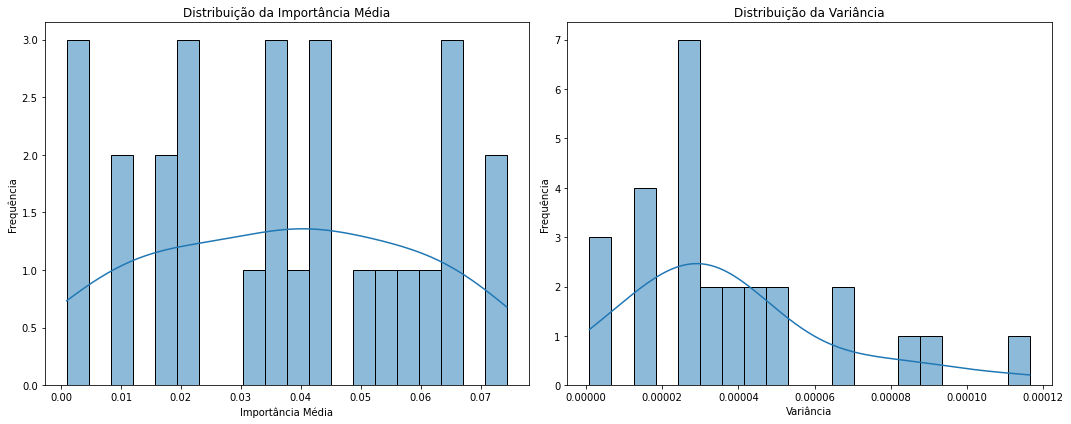

,Mean Importance,Variance
count,27.000000,2.700000e+01
mean,0.037037,3.753344e-05
std,0.022601,2.782792e-05
min,0.000941,9.825368e-07
25%,0.019211,2.167609e-05
50%,0.036671,2.972226e-05
75%,0.055494,4.605651e-05
max,0.074370,1.163975e-04


In [ ]:
# import seaborn as sns

# Calculando estatísticas descritivas para as colunas "Mean Importance" e "Variance"
desc_stats = summary_df[['Mean Importance', 'Variance']].describe()

# Visualização da distribuição da importância média e da variância
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot para a importância média
sns.histplot(summary_df['Mean Importance'], bins=20, kde=True, ax=axes[0])
axes[0].set_title('Distribuição da Importância Média')
axes[0].set_xlabel('Importância Média')
axes[0].set_ylabel('Frequência')

# Plot para a variância
sns.histplot(summary_df['Variance'], bins=20, kde=True, ax=axes[1])
axes[1].set_title('Distribuição da Variância')
axes[1].set_xlabel('Variância')
axes[1].set_ylabel('Frequência')

plt.tight_layout()
plt.show()

desc_stats


- Importância das Características: Algumas características são claramente mais importantes do que outras. Isso é evidenciado pela ampla variação na importância média e pela tendência de algumas características de terem valores mais altos de importância.

- Variabilidade entre as Ligas: A presença de uma variância significativa em algumas características indica que o impacto dessas características varia entre as diferentes ligas. Isso sugere que pode ser benéfico ajustar modelos separados para cada liga, especialmente para as características com maior variância.

- Decisão sobre Modelos Separados: Embora a média da variância não seja excepcionalmente alta, o fato de existirem características com variâncias relativamente altas (próximas do valor máximo) sugere que uma abordagem diferenciada para cada liga pode ser justificada.

In [ ]:
dataframe_league

,cv_auc_mean,train_auc,test_auc,feature_importance
England - Championship,0.882526,0.961639,0.894844,"[0.07846449317630746, 0.047039112450297425, 0...."
Italy - Serie B,0.924878,0.988153,0.914985,"[0.05697678583585177, 0.02716547506956606, 0.0..."
Germany - Bundesliga,0.881877,0.971801,0.893718,"[0.06593974633194613, 0.03427299656896691, 0.0..."
Brazil - Serie A,0.866392,0.949456,0.854812,"[0.06713153294976561, 0.0389881284847802, 0.03..."
Mexico - Liga MX,0.911532,0.983993,0.900703,"[0.06174618511410279, 0.02397219229302959, 0.0..."
England - Premier League,0.852494,0.941160,0.856625,"[0.06298916931967175, 0.03514118589582654, 0.0..."
France - Ligue 1,0.882856,0.970198,0.854575,"[0.07802024199435718, 0.029892810652392507, 0...."
USA - Major League Soccer,0.853506,0.947884,0.851369,"[0.08207372925958437, 0.032764080709332045, 0...."
Spain - La Liga 2,0.924718,0.987625,0.927849,"[0.05795487245847749, 0.02998985615723257, 0.0..."
Argentina - Superliga,0.887638,0.958241,0.872633,"[0.07793489555083194, 0.0344202983754707, 0.03..."


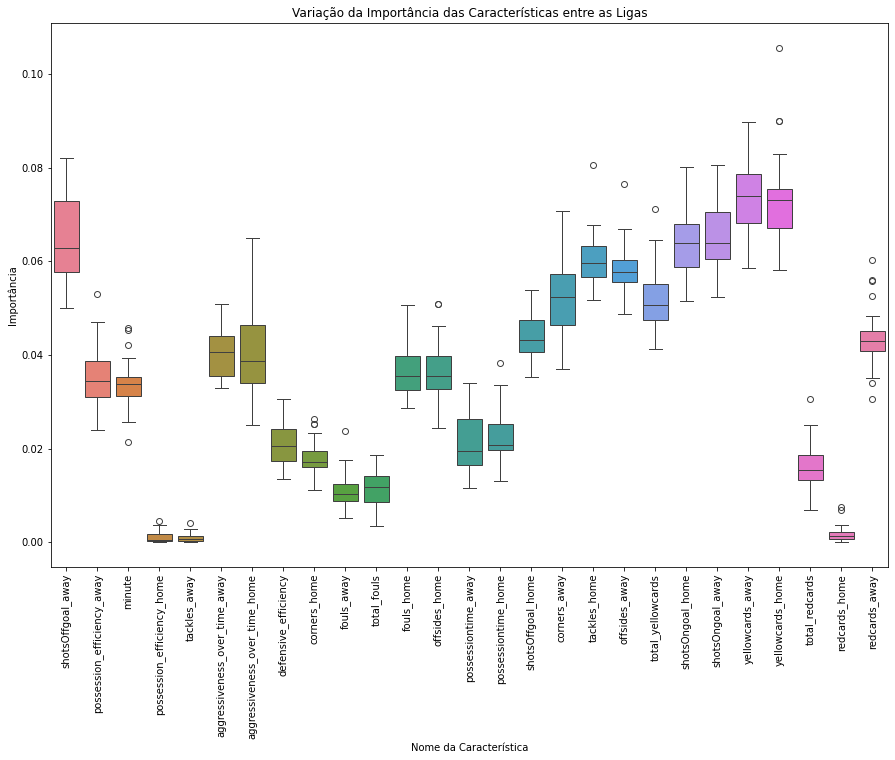

In [ ]:
def convert_to_list(ndarray):
    # Verifica se o ndarray não é vazio e converte para lista
    return ndarray.tolist() if ndarray.size else []

importance_lists = dataframe_league['feature_importance'].apply(convert_to_list)

# Criando um DataFrame para armazenar os valores de importância para todas as ligas
feature_importance_df = pd.DataFrame(importance_lists.tolist())

# Calculando estatísticas descritivas para cada característica em todas as ligas
feature_importance_stats = feature_importance_df.describe()

feature_names = summary_df['Feature Name'].tolist()

# Criar o gráfico de boxplot
fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(data=feature_importance_df)
ax.set_title('Variação da Importância das Características entre as Ligas')
ax.set_xlabel('Nome da Característica')
ax.set_ylabel('Importância')
plt.xticks(ticks=np.arange(len(feature_names)), labels=feature_names, rotation=90)
plt.show()


- Variação na Importância: Características com boxplots mais largos indicam uma maior variação na sua importância entre as ligas. Isso sugere que o impacto dessas características é mais específico para cada liga. Por outro lado, características com boxplots mais estreitos mostram uma consistência maior, indicando que a importância dessas características é mais uniforme entre as ligas.
Outliers:

- Alguns boxplots têm pontos outliers, que representam ligas onde a importância da característica é notavelmente diferente do padrão observado na maioria das outras ligas. Esses outliers podem indicar casos específicos onde uma característica é particularmente mais ou menos relevante.

- Modelos Personalizados para Ligas: As características com maior variação (boxplots mais largos e/ou com outliers) são fortes candidatas a justificar a criação de modelos separados para cada liga. Isso permitiria que os modelos levassem em conta as peculiaridades de cada liga, resultando em previsões mais precisas.

- Características com menor variação podem ser tratadas de forma mais consistente entre os modelos para diferentes ligas.

In [ ]:
summary_df.to_csv('df_leagues_avaliation.csv', index=False, encoding='utf-8')

### Treinando Rede para cada liga baseado em busca aleatória de parâmetro

In [ ]:
# Função para criar e aplicar o transformador de colunas
def create_preprocessor(X):
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
        ],
        remainder='passthrough'  # Mantém as características categóricas sem transformação
    )
    return preprocessor.fit(X)



Treinando modelo para a liga: England - Championship
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
47/47 [==============================] - 1s 5ms/step - loss: 0.7781 - accuracy: 0.5186 - val_loss: 0.6900 - val_accuracy: 0.5378 - lr: 0.0011
Epoch 2/300
47/47 [==============================] - 0s 3ms/step - loss: 0.7090 - accuracy: 0.5406 - val_loss: 0.6909 - val_accuracy: 0.5644 - lr: 0.0011
Epoch 3/300
47/47 [==============================] - 0s 3ms/step - loss: 0.7022 - accuracy: 0.5293 - val_loss: 0.6887 - val_accuracy: 0.5538 - lr: 0.0011
Epoch 4/300
47/47 [==============================] - 0s 3ms/step - loss: 0.6951 - accuracy: 0.5283 - val_loss: 0.6898 - val_accuracy: 0.5299 - lr: 0.0011
Epoch 5/300
47/47 [==============================] - 0s 2ms/step - loss: 0.6942 - accuracy: 0.5263 - val_loss: 0.6893 - val_accuracy: 0.5219 - lr: 0.0011
Epoch 6/300
47/47 [========

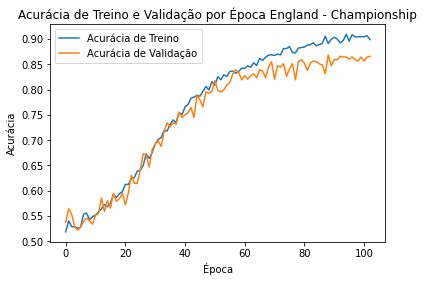

Treinando modelo para a liga: Italy - Serie B
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
31/31 [==============================] - 1s 7ms/step - loss: 1.1325 - accuracy: 0.4929 - val_loss: 0.9608 - val_accuracy: 0.4431 - lr: 4.9914e-04
Epoch 2/300
31/31 [==============================] - 0s 3ms/step - loss: 1.0076 - accuracy: 0.5112 - val_loss: 0.9414 - val_accuracy: 0.4817 - lr: 4.9914e-04
Epoch 3/300
31/31 [==============================] - 0s 3ms/step - loss: 0.9654 - accuracy: 0.5117 - val_loss: 0.9229 - val_accuracy: 0.5467 - lr: 4.9914e-04
Epoch 4/300
31/31 [==============================] - 0s 3ms/step - loss: 0.9511 - accuracy: 0.5264 - val_loss: 0.9165 - val_accuracy: 0.5061 - lr: 4.9914e-04
Epoch 5/300
31/31 [==============================] - 0s 3ms/step - loss: 0.9307 - accuracy: 0.4903 - val_loss: 0.9050 - val_accuracy: 0.5163 - lr: 4.9914e-04
Epoch 6/300
31

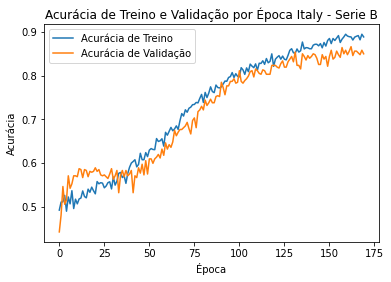

Treinando modelo para a liga: Germany - Bundesliga
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
51/51 [==============================] - 1s 6ms/step - loss: 0.8340 - accuracy: 0.5129 - val_loss: 0.7393 - val_accuracy: 0.5399 - lr: 7.1039e-04
Epoch 2/300
51/51 [==============================] - 0s 3ms/step - loss: 0.7628 - accuracy: 0.5172 - val_loss: 0.7382 - val_accuracy: 0.5411 - lr: 7.1039e-04
Epoch 3/300
51/51 [==============================] - 0s 3ms/step - loss: 0.7478 - accuracy: 0.5141 - val_loss: 0.7410 - val_accuracy: 0.4798 - lr: 7.1039e-04
Epoch 4/300
51/51 [==============================] - 0s 3ms/step - loss: 0.7375 - accuracy: 0.5371 - val_loss: 0.7351 - val_accuracy: 0.5301 - lr: 7.1039e-04
Epoch 5/300
51/51 [==============================] - 0s 3ms/step - loss: 0.7402 - accuracy: 0.5270 - val_loss: 0.7355 - val_accuracy: 0.5239 - lr: 7.1039e-04
Epoch 6/3

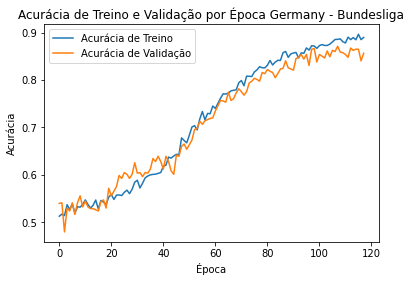

Treinando modelo para a liga: Brazil - Serie A
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
64/64 [==============================] - 1s 5ms/step - loss: 1.1546 - accuracy: 0.5037 - val_loss: 0.8551 - val_accuracy: 0.5088 - lr: 3.0238e-04
Epoch 2/300
64/64 [==============================] - 0s 3ms/step - loss: 0.9559 - accuracy: 0.5081 - val_loss: 0.8405 - val_accuracy: 0.5264 - lr: 3.0238e-04
Epoch 3/300
64/64 [==============================] - 0s 3ms/step - loss: 0.9115 - accuracy: 0.4956 - val_loss: 0.8351 - val_accuracy: 0.5342 - lr: 3.0238e-04
Epoch 4/300
64/64 [==============================] - 0s 3ms/step - loss: 0.8692 - accuracy: 0.5059 - val_loss: 0.8297 - val_accuracy: 0.5381 - lr: 3.0238e-04
Epoch 5/300
64/64 [==============================] - 0s 3ms/step - loss: 0.8487 - accuracy: 0.5208 - val_loss: 0.8261 - val_accuracy: 0.5293 - lr: 3.0238e-04
Epoch 6/300
6

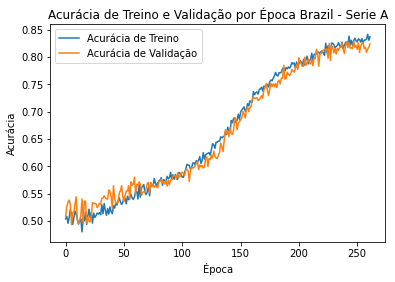

Treinando modelo para a liga: Mexico - Liga MX
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
33/33 [==============================] - 1s 7ms/step - loss: 0.8881 - accuracy: 0.5088 - val_loss: 0.7242 - val_accuracy: 0.5419 - lr: 4.9775e-04
Epoch 2/300
33/33 [==============================] - 0s 3ms/step - loss: 0.7768 - accuracy: 0.5132 - val_loss: 0.7231 - val_accuracy: 0.5185 - lr: 4.9775e-04
Epoch 3/300
33/33 [==============================] - 0s 3ms/step - loss: 0.7513 - accuracy: 0.5171 - val_loss: 0.7176 - val_accuracy: 0.5478 - lr: 4.9775e-04
Epoch 4/300
33/33 [==============================] - 0s 3ms/step - loss: 0.7459 - accuracy: 0.4995 - val_loss: 0.7185 - val_accuracy: 0.5673 - lr: 4.9775e-04
Epoch 5/300
33/33 [==============================] - 0s 3ms/step - loss: 0.7359 - accuracy: 0.5127 - val_loss: 0.7186 - val_accuracy: 0.5478 - lr: 4.9775e-04
Epoch 6/300
3

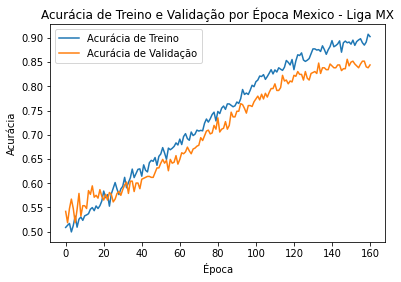

Treinando modelo para a liga: England - Premier League
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
103/103 [==============================] - 1s 4ms/step - loss: 0.7887 - accuracy: 0.5119 - val_loss: 0.7099 - val_accuracy: 0.5180 - lr: 0.0019
Epoch 2/300
103/103 [==============================] - 0s 3ms/step - loss: 0.7222 - accuracy: 0.5134 - val_loss: 0.7065 - val_accuracy: 0.5223 - lr: 0.0019
Epoch 3/300
103/103 [==============================] - 0s 3ms/step - loss: 0.7117 - accuracy: 0.5171 - val_loss: 0.7055 - val_accuracy: 0.5217 - lr: 0.0019
Epoch 4/300
103/103 [==============================] - 0s 3ms/step - loss: 0.7071 - accuracy: 0.5241 - val_loss: 0.7052 - val_accuracy: 0.5223 - lr: 0.0019
Epoch 5/300
103/103 [==============================] - 0s 3ms/step - loss: 0.7083 - accuracy: 0.5202 - val_loss: 0.7050 - val_accuracy: 0.5217 - lr: 0.0019
Epoch 6/300
103

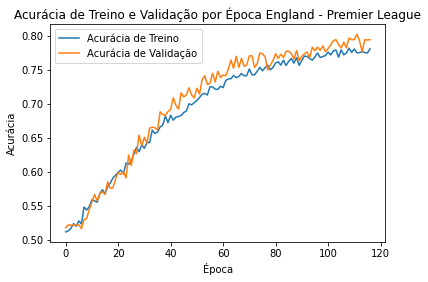

Treinando modelo para a liga: France - Ligue 1
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
39/39 [==============================] - 1s 6ms/step - loss: 0.8995 - accuracy: 0.5087 - val_loss: 0.7757 - val_accuracy: 0.5388 - lr: 0.0013
Epoch 2/300
39/39 [==============================] - 0s 3ms/step - loss: 0.7919 - accuracy: 0.5180 - val_loss: 0.7671 - val_accuracy: 0.5469 - lr: 0.0013
Epoch 3/300
39/39 [==============================] - 0s 3ms/step - loss: 0.7746 - accuracy: 0.5196 - val_loss: 0.7601 - val_accuracy: 0.5421 - lr: 0.0013
Epoch 4/300
39/39 [==============================] - 0s 3ms/step - loss: 0.7690 - accuracy: 0.5261 - val_loss: 0.7622 - val_accuracy: 0.5000 - lr: 0.0013
Epoch 5/300
39/39 [==============================] - 0s 3ms/step - loss: 0.7575 - accuracy: 0.5423 - val_loss: 0.7552 - val_accuracy: 0.5129 - lr: 0.0013
Epoch 6/300
39/39 [==============

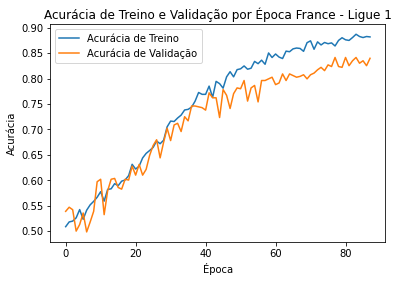

Treinando modelo para a liga: USA - Major League Soccer
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
101/101 [==============================] - 1s 4ms/step - loss: 1.0074 - accuracy: 0.5053 - val_loss: 0.8859 - val_accuracy: 0.5446 - lr: 2.2768e-04
Epoch 2/300
101/101 [==============================] - 0s 3ms/step - loss: 0.9162 - accuracy: 0.5122 - val_loss: 0.8715 - val_accuracy: 0.5254 - lr: 2.2768e-04
Epoch 3/300
101/101 [==============================] - 0s 3ms/step - loss: 0.8833 - accuracy: 0.5210 - val_loss: 0.8584 - val_accuracy: 0.5285 - lr: 2.2768e-04
Epoch 4/300
101/101 [==============================] - 0s 3ms/step - loss: 0.8671 - accuracy: 0.5208 - val_loss: 0.8495 - val_accuracy: 0.5266 - lr: 2.2768e-04
Epoch 5/300
101/101 [==============================] - 0s 3ms/step - loss: 0.8516 - accuracy: 0.5314 - val_loss: 0.8406 - val_accuracy: 0.5242 - lr: 2.276

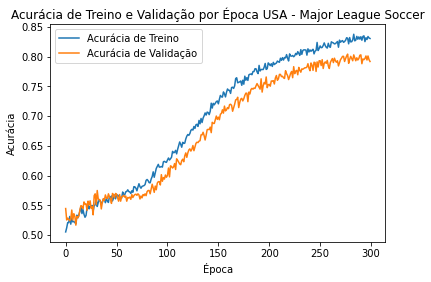

Treinando modelo para a liga: Spain - La Liga 2
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
35/35 [==============================] - 1s 7ms/step - loss: 0.9621 - accuracy: 0.4847 - val_loss: 0.7024 - val_accuracy: 0.5310 - lr: 0.0014
Epoch 2/300
35/35 [==============================] - 0s 3ms/step - loss: 0.7387 - accuracy: 0.5249 - val_loss: 0.7014 - val_accuracy: 0.5456 - lr: 0.0014
Epoch 3/300
35/35 [==============================] - 0s 3ms/step - loss: 0.7255 - accuracy: 0.5185 - val_loss: 0.7013 - val_accuracy: 0.5255 - lr: 0.0014
Epoch 4/300
35/35 [==============================] - 0s 3ms/step - loss: 0.7248 - accuracy: 0.5094 - val_loss: 0.7002 - val_accuracy: 0.5365 - lr: 0.0014
Epoch 5/300
35/35 [==============================] - 0s 3ms/step - loss: 0.7156 - accuracy: 0.5158 - val_loss: 0.7000 - val_accuracy: 0.5328 - lr: 0.0014
Epoch 6/300
35/35 [=============

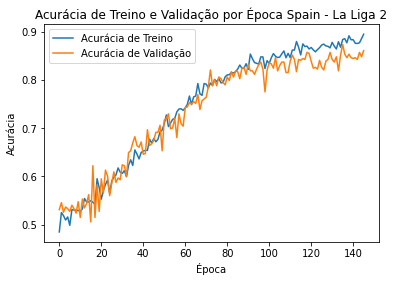

Treinando modelo para a liga: Argentina - Superliga
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
64/64 [==============================] - 2s 5ms/step - loss: 0.8486 - accuracy: 0.4914 - val_loss: 0.6986 - val_accuracy: 0.5363 - lr: 4.3507e-04
Epoch 2/300
64/64 [==============================] - 0s 3ms/step - loss: 0.7375 - accuracy: 0.5079 - val_loss: 0.6989 - val_accuracy: 0.5392 - lr: 4.3507e-04
Epoch 3/300
64/64 [==============================] - 0s 3ms/step - loss: 0.7190 - accuracy: 0.5120 - val_loss: 0.6994 - val_accuracy: 0.5255 - lr: 4.3507e-04
Epoch 4/300
64/64 [==============================] - 0s 3ms/step - loss: 0.7169 - accuracy: 0.5172 - val_loss: 0.7004 - val_accuracy: 0.4980 - lr: 4.3507e-04
Epoch 5/300
64/64 [==============================] - 0s 3ms/step - loss: 0.7066 - accuracy: 0.5250 - val_loss: 0.6977 - val_accuracy: 0.5520 - lr: 4.3507e-04
Epoch 6/

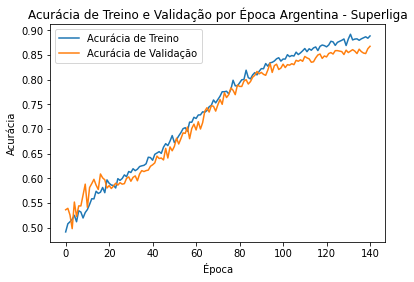

Treinando modelo para a liga: England - League One
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
41/41 [==============================] - 1s 6ms/step - loss: 0.9343 - accuracy: 0.5103 - val_loss: 0.7618 - val_accuracy: 0.4427 - lr: 8.2353e-04
Epoch 2/300
41/41 [==============================] - 0s 3ms/step - loss: 0.7990 - accuracy: 0.5054 - val_loss: 0.7481 - val_accuracy: 0.5145 - lr: 8.2353e-04
Epoch 3/300
41/41 [==============================] - 0s 3ms/step - loss: 0.7822 - accuracy: 0.5084 - val_loss: 0.7498 - val_accuracy: 0.4519 - lr: 8.2353e-04
Epoch 4/300
41/41 [==============================] - 0s 3ms/step - loss: 0.7712 - accuracy: 0.5241 - val_loss: 0.7451 - val_accuracy: 0.5359 - lr: 8.2353e-04
Epoch 5/300
41/41 [==============================] - 0s 3ms/step - loss: 0.7548 - accuracy: 0.5122 - val_loss: 0.7438 - val_accuracy: 0.5084 - lr: 8.2353e-04
Epoch 6/3

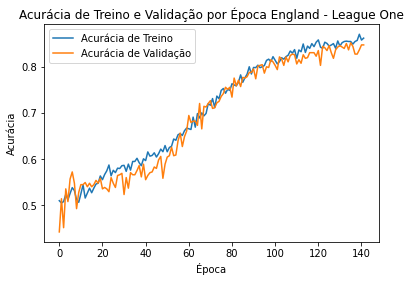

Treinando modelo para a liga: Europe - Euro Qualification
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
17/17 [==============================] - 1s 12ms/step - loss: 1.0012 - accuracy: 0.5168 - val_loss: 0.7947 - val_accuracy: 0.5224 - lr: 0.0022
Epoch 2/300
17/17 [==============================] - 0s 4ms/step - loss: 0.8499 - accuracy: 0.5149 - val_loss: 0.7766 - val_accuracy: 0.5821 - lr: 0.0022
Epoch 3/300
17/17 [==============================] - 0s 4ms/step - loss: 0.8060 - accuracy: 0.5308 - val_loss: 0.7818 - val_accuracy: 0.5373 - lr: 0.0022
Epoch 4/300
17/17 [==============================] - 0s 4ms/step - loss: 0.7990 - accuracy: 0.5308 - val_loss: 0.7733 - val_accuracy: 0.5709 - lr: 0.0022
Epoch 5/300
17/17 [==============================] - 0s 4ms/step - loss: 0.7786 - accuracy: 0.5522 - val_loss: 0.7709 - val_accuracy: 0.5410 - lr: 0.0022
Epoch 6/300
17/17 [==

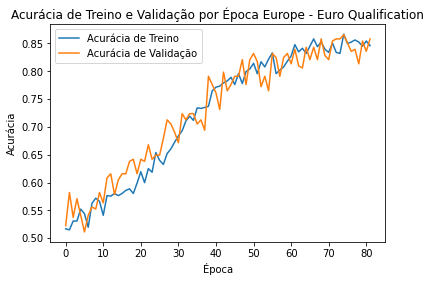

Treinando modelo para a liga: Asia - AFC Champions League
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
15/15 [==============================] - 1s 13ms/step - loss: 0.8469 - accuracy: 0.5178 - val_loss: 0.7773 - val_accuracy: 0.4686 - lr: 0.0023
Epoch 2/300
15/15 [==============================] - 0s 5ms/step - loss: 0.7766 - accuracy: 0.5126 - val_loss: 0.7178 - val_accuracy: 0.5356 - lr: 0.0023
Epoch 3/300
15/15 [==============================] - 0s 4ms/step - loss: 0.7478 - accuracy: 0.5042 - val_loss: 0.7369 - val_accuracy: 0.4812 - lr: 0.0023
Epoch 4/300
15/15 [==============================] - 0s 4ms/step - loss: 0.7192 - accuracy: 0.5377 - val_loss: 0.7098 - val_accuracy: 0.5690 - lr: 0.0023
Epoch 5/300
15/15 [==============================] - 0s 4ms/step - loss: 0.7329 - accuracy: 0.5283 - val_loss: 0.7079 - val_accuracy: 0.5523 - lr: 0.0023
Epoch 6/300
15/15 [==

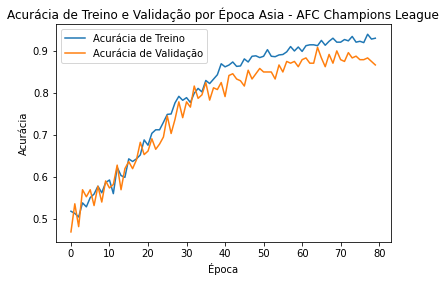

Treinando modelo para a liga: Saudi Arabia - Pro League
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
29/29 [==============================] - 1s 10ms/step - loss: 0.8221 - accuracy: 0.5244 - val_loss: 0.7275 - val_accuracy: 0.4967 - lr: 0.0011
Epoch 2/300
29/29 [==============================] - 0s 4ms/step - loss: 0.7412 - accuracy: 0.4978 - val_loss: 0.7084 - val_accuracy: 0.5388 - lr: 0.0011
Epoch 3/300
29/29 [==============================] - 0s 4ms/step - loss: 0.7194 - accuracy: 0.5183 - val_loss: 0.7055 - val_accuracy: 0.5521 - lr: 0.0011
Epoch 4/300
29/29 [==============================] - 0s 4ms/step - loss: 0.7185 - accuracy: 0.5322 - val_loss: 0.7037 - val_accuracy: 0.5011 - lr: 0.0011
Epoch 5/300
29/29 [==============================] - 0s 4ms/step - loss: 0.7151 - accuracy: 0.5267 - val_loss: 0.7033 - val_accuracy: 0.5166 - lr: 0.0011
Epoch 6/300
29/29 [====

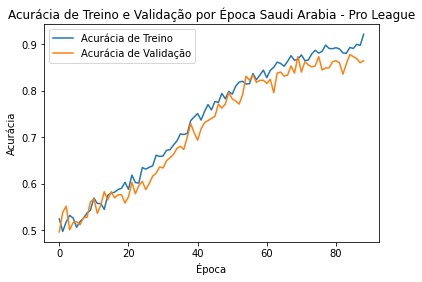

Treinando modelo para a liga: Scotland - Premiership
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
22/22 [==============================] - 1s 9ms/step - loss: 0.8210 - accuracy: 0.5142 - val_loss: 0.6853 - val_accuracy: 0.5881 - lr: 9.8082e-04
Epoch 2/300
22/22 [==============================] - 0s 3ms/step - loss: 0.7375 - accuracy: 0.5249 - val_loss: 0.6779 - val_accuracy: 0.6080 - lr: 9.8082e-04
Epoch 3/300
22/22 [==============================] - 0s 3ms/step - loss: 0.7100 - accuracy: 0.5249 - val_loss: 0.6773 - val_accuracy: 0.5938 - lr: 9.8082e-04
Epoch 4/300
22/22 [==============================] - 0s 3ms/step - loss: 0.7065 - accuracy: 0.5547 - val_loss: 0.6787 - val_accuracy: 0.5966 - lr: 9.8082e-04
Epoch 5/300
22/22 [==============================] - 0s 3ms/step - loss: 0.6995 - accuracy: 0.5767 - val_loss: 0.6730 - val_accuracy: 0.6108 - lr: 9.8082e-04
Epoch 6

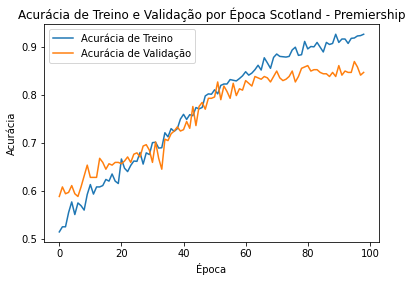

Treinando modelo para a liga: England - League Two
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
44/44 [==============================] - 1s 6ms/step - loss: 0.8201 - accuracy: 0.5257 - val_loss: 0.7423 - val_accuracy: 0.5991 - lr: 7.9044e-04
Epoch 2/300
44/44 [==============================] - 0s 3ms/step - loss: 0.7568 - accuracy: 0.5485 - val_loss: 0.7386 - val_accuracy: 0.6020 - lr: 7.9044e-04
Epoch 3/300
44/44 [==============================] - 0s 3ms/step - loss: 0.7513 - accuracy: 0.5619 - val_loss: 0.7318 - val_accuracy: 0.6078 - lr: 7.9044e-04
Epoch 4/300
44/44 [==============================] - 0s 3ms/step - loss: 0.7386 - accuracy: 0.5612 - val_loss: 0.7338 - val_accuracy: 0.6151 - lr: 7.9044e-04
Epoch 5/300
44/44 [==============================] - 0s 4ms/step - loss: 0.7406 - accuracy: 0.5706 - val_loss: 0.7316 - val_accuracy: 0.6006 - lr: 7.9044e-04
Epoch 6/3

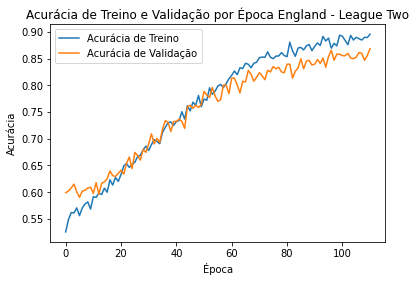

Treinando modelo para a liga: South America - Copa Libertadores
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
41/41 [==============================] - 1s 7ms/step - loss: 0.7701 - accuracy: 0.4982 - val_loss: 0.6983 - val_accuracy: 0.5093 - lr: 0.0011
Epoch 2/300
41/41 [==============================] - 0s 3ms/step - loss: 0.7138 - accuracy: 0.5201 - val_loss: 0.7013 - val_accuracy: 0.4813 - lr: 0.0011
Epoch 3/300
41/41 [==============================] - 0s 3ms/step - loss: 0.7084 - accuracy: 0.5088 - val_loss: 0.7051 - val_accuracy: 0.4751 - lr: 0.0011
Epoch 4/300
41/41 [==============================] - 0s 3ms/step - loss: 0.7066 - accuracy: 0.4955 - val_loss: 0.6963 - val_accuracy: 0.5249 - lr: 0.0011
Epoch 5/300
41/41 [==============================] - 0s 3ms/step - loss: 0.6979 - accuracy: 0.5298 - val_loss: 0.6929 - val_accuracy: 0.5452 - lr: 0.0011
Epoch 6/300
41/4

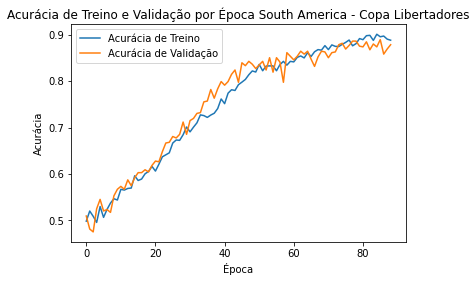

Treinando modelo para a liga: Spain - La Liga
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
57/57 [==============================] - 1s 5ms/step - loss: 0.7713 - accuracy: 0.5199 - val_loss: 0.6936 - val_accuracy: 0.5514 - lr: 0.0030
Epoch 2/300
57/57 [==============================] - 0s 3ms/step - loss: 0.7022 - accuracy: 0.5517 - val_loss: 0.6947 - val_accuracy: 0.5657 - lr: 0.0030
Epoch 3/300
57/57 [==============================] - 0s 3ms/step - loss: 0.6959 - accuracy: 0.5522 - val_loss: 0.6932 - val_accuracy: 0.5657 - lr: 0.0030
Epoch 4/300
57/57 [==============================] - 0s 3ms/step - loss: 0.6979 - accuracy: 0.5519 - val_loss: 0.6928 - val_accuracy: 0.5591 - lr: 0.0030
Epoch 5/300
57/57 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5475 - val_loss: 0.6901 - val_accuracy: 0.5746 - lr: 0.0030
Epoch 6/300
57/57 [===============

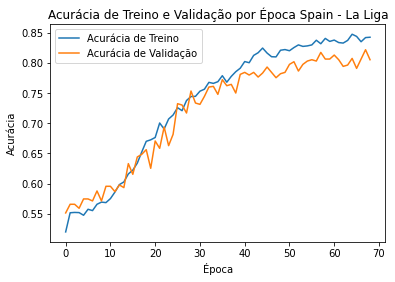

Treinando modelo para a liga: Europe - Champions League
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
37/37 [==============================] - 1s 7ms/step - loss: 1.0506 - accuracy: 0.5133 - val_loss: 0.8544 - val_accuracy: 0.5431 - lr: 2.5781e-04
Epoch 2/300
37/37 [==============================] - 0s 4ms/step - loss: 0.9334 - accuracy: 0.5044 - val_loss: 0.8423 - val_accuracy: 0.5245 - lr: 2.5781e-04
Epoch 3/300
37/37 [==============================] - 0s 4ms/step - loss: 0.9125 - accuracy: 0.4896 - val_loss: 0.8347 - val_accuracy: 0.5618 - lr: 2.5781e-04
Epoch 4/300
37/37 [==============================] - 0s 4ms/step - loss: 0.8757 - accuracy: 0.5184 - val_loss: 0.8314 - val_accuracy: 0.5330 - lr: 2.5781e-04
Epoch 5/300
37/37 [==============================] - 0s 4ms/step - loss: 0.8704 - accuracy: 0.5061 - val_loss: 0.8292 - val_accuracy: 0.5262 - lr: 2.5781e-04
Epoc

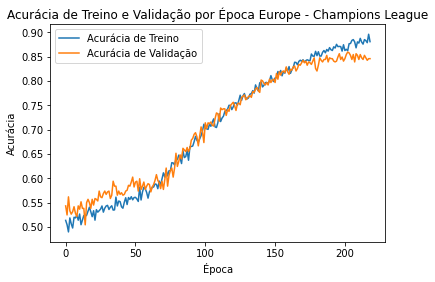

Treinando modelo para a liga: Europe - Europa League
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
27/27 [==============================] - 1s 8ms/step - loss: 0.9594 - accuracy: 0.5164 - val_loss: 0.7031 - val_accuracy: 0.4918 - lr: 0.0026
Epoch 2/300
27/27 [==============================] - 0s 3ms/step - loss: 0.7435 - accuracy: 0.5000 - val_loss: 0.6951 - val_accuracy: 0.5457 - lr: 0.0026
Epoch 3/300
27/27 [==============================] - 0s 3ms/step - loss: 0.7141 - accuracy: 0.5070 - val_loss: 0.6942 - val_accuracy: 0.5386 - lr: 0.0026
Epoch 4/300
27/27 [==============================] - 0s 3ms/step - loss: 0.7075 - accuracy: 0.5304 - val_loss: 0.6956 - val_accuracy: 0.5152 - lr: 0.0026
Epoch 5/300
27/27 [==============================] - 0s 3ms/step - loss: 0.7025 - accuracy: 0.5275 - val_loss: 0.6929 - val_accuracy: 0.5433 - lr: 0.0026
Epoch 6/300
27/27 [========

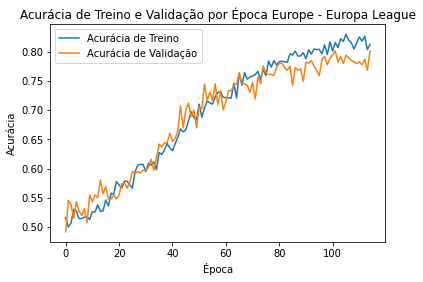

Treinando modelo para a liga: Greece - Super League
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
19/19 [==============================] - 1s 11ms/step - loss: 1.0315 - accuracy: 0.5096 - val_loss: 0.9206 - val_accuracy: 0.4916 - lr: 0.0019
Epoch 2/300
19/19 [==============================] - 0s 4ms/step - loss: 0.9296 - accuracy: 0.5146 - val_loss: 0.8839 - val_accuracy: 0.4950 - lr: 0.0019
Epoch 3/300
19/19 [==============================] - 0s 4ms/step - loss: 0.8766 - accuracy: 0.5197 - val_loss: 0.8560 - val_accuracy: 0.4983 - lr: 0.0019
Epoch 4/300
19/19 [==============================] - 0s 4ms/step - loss: 0.8532 - accuracy: 0.5448 - val_loss: 0.8327 - val_accuracy: 0.5686 - lr: 0.0019
Epoch 5/300
19/19 [==============================] - 0s 4ms/step - loss: 0.8351 - accuracy: 0.5331 - val_loss: 0.8217 - val_accuracy: 0.5284 - lr: 0.0019
Epoch 6/300
19/19 [========

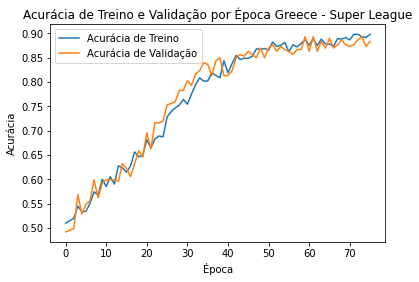

Treinando modelo para a liga: Denmark - Superliga
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
17/17 [==============================] - 1s 12ms/step - loss: 1.2172 - accuracy: 0.5172 - val_loss: 0.8637 - val_accuracy: 0.5948 - lr: 6.4789e-04
Epoch 2/300
17/17 [==============================] - 0s 4ms/step - loss: 1.0622 - accuracy: 0.5331 - val_loss: 0.8269 - val_accuracy: 0.5613 - lr: 6.4789e-04
Epoch 3/300
17/17 [==============================] - 0s 4ms/step - loss: 1.0025 - accuracy: 0.5005 - val_loss: 0.8269 - val_accuracy: 0.5204 - lr: 6.4789e-04
Epoch 4/300
17/17 [==============================] - 0s 5ms/step - loss: 0.9216 - accuracy: 0.5396 - val_loss: 0.8224 - val_accuracy: 0.4981 - lr: 6.4789e-04
Epoch 5/300
17/17 [==============================] - 0s 4ms/step - loss: 0.9047 - accuracy: 0.5144 - val_loss: 0.8175 - val_accuracy: 0.5279 - lr: 6.4789e-04
Epoch 6/3

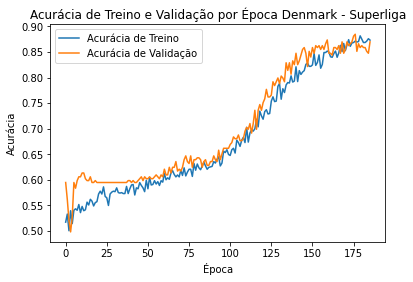

Treinando modelo para a liga: Australia - A-League
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
26/26 [==============================] - 1s 9ms/step - loss: 0.9516 - accuracy: 0.5140 - val_loss: 0.6878 - val_accuracy: 0.5810 - lr: 0.0027
Epoch 2/300
26/26 [==============================] - 0s 3ms/step - loss: 0.7346 - accuracy: 0.5577 - val_loss: 0.6860 - val_accuracy: 0.5810 - lr: 0.0027
Epoch 3/300
26/26 [==============================] - 0s 3ms/step - loss: 0.7103 - accuracy: 0.5552 - val_loss: 0.6844 - val_accuracy: 0.5810 - lr: 0.0027
Epoch 4/300
26/26 [==============================] - 0s 3ms/step - loss: 0.6983 - accuracy: 0.5590 - val_loss: 0.6857 - val_accuracy: 0.5810 - lr: 0.0027
Epoch 5/300
26/26 [==============================] - 0s 3ms/step - loss: 0.6967 - accuracy: 0.5733 - val_loss: 0.6828 - val_accuracy: 0.5810 - lr: 0.0027
Epoch 6/300
26/26 [==========

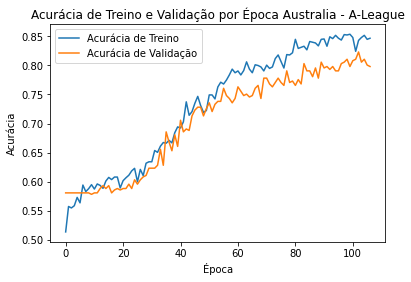

Treinando modelo para a liga: South America - Copa Sudamericana
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
26/26 [==============================] - 1s 8ms/step - loss: 1.2717 - accuracy: 0.5181 - val_loss: 0.8790 - val_accuracy: 0.4940 - lr: 7.1828e-04
Epoch 2/300
26/26 [==============================] - 0s 3ms/step - loss: 1.0324 - accuracy: 0.5133 - val_loss: 0.8611 - val_accuracy: 0.5205 - lr: 7.1828e-04
Epoch 3/300
26/26 [==============================] - 0s 3ms/step - loss: 0.9461 - accuracy: 0.5325 - val_loss: 0.8545 - val_accuracy: 0.4916 - lr: 7.1828e-04
Epoch 4/300
26/26 [==============================] - 0s 3ms/step - loss: 0.9114 - accuracy: 0.5139 - val_loss: 0.8481 - val_accuracy: 0.4916 - lr: 7.1828e-04
Epoch 5/300
26/26 [==============================] - 0s 3ms/step - loss: 0.9202 - accuracy: 0.4771 - val_loss: 0.8455 - val_accuracy: 0.5084 - lr: 7.1828e

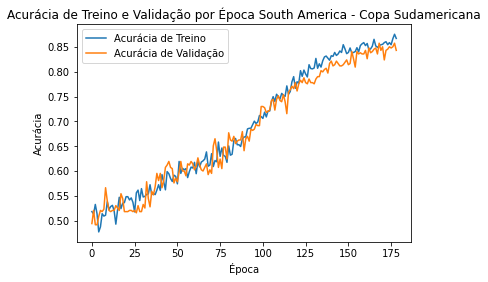

Treinando modelo para a liga: Portugal - Liga Portugal
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
26/26 [==============================] - 1s 9ms/step - loss: 0.8363 - accuracy: 0.5126 - val_loss: 0.6940 - val_accuracy: 0.5345 - lr: 0.0057
Epoch 2/300
26/26 [==============================] - 0s 4ms/step - loss: 0.7122 - accuracy: 0.4948 - val_loss: 0.6951 - val_accuracy: 0.5665 - lr: 0.0057
Epoch 3/300
26/26 [==============================] - 0s 4ms/step - loss: 0.6989 - accuracy: 0.5342 - val_loss: 0.6849 - val_accuracy: 0.5936 - lr: 0.0057
Epoch 4/300
26/26 [==============================] - 0s 4ms/step - loss: 0.6927 - accuracy: 0.5404 - val_loss: 0.6862 - val_accuracy: 0.6158 - lr: 0.0057
Epoch 5/300
26/26 [==============================] - 0s 4ms/step - loss: 0.6947 - accuracy: 0.5626 - val_loss: 0.6872 - val_accuracy: 0.6010 - lr: 0.0057
Epoch 6/300
26/26 [======

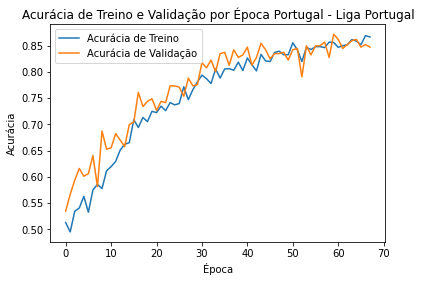

Treinando modelo para a liga: England - Carabao Cup
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
13/13 [==============================] - 1s 15ms/step - loss: 1.2305 - accuracy: 0.4787 - val_loss: 0.7805 - val_accuracy: 0.5100 - lr: 0.0075
Epoch 2/300
13/13 [==============================] - 0s 5ms/step - loss: 0.8257 - accuracy: 0.4963 - val_loss: 0.7809 - val_accuracy: 0.4600 - lr: 0.0075
Epoch 3/300
13/13 [==============================] - 0s 4ms/step - loss: 0.7698 - accuracy: 0.5125 - val_loss: 0.7818 - val_accuracy: 0.5050 - lr: 0.0075
Epoch 4/300
13/13 [==============================] - 0s 5ms/step - loss: 0.7769 - accuracy: 0.5288 - val_loss: 0.7645 - val_accuracy: 0.4750 - lr: 0.0075
Epoch 5/300
13/13 [==============================] - 0s 4ms/step - loss: 0.7573 - accuracy: 0.5188 - val_loss: 0.7633 - val_accuracy: 0.5350 - lr: 0.0075
Epoch 6/300
13/13 [========

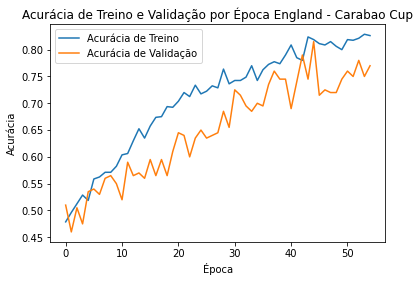

Treinando modelo para a liga: Romania - Liga 1
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
16/16 [==============================] - 1s 12ms/step - loss: 0.8977 - accuracy: 0.5460 - val_loss: 0.6884 - val_accuracy: 0.5661 - lr: 0.0029
Epoch 2/300
16/16 [==============================] - 0s 4ms/step - loss: 0.7205 - accuracy: 0.5543 - val_loss: 0.6965 - val_accuracy: 0.5372 - lr: 0.0029
Epoch 3/300
16/16 [==============================] - 0s 4ms/step - loss: 0.7013 - accuracy: 0.5667 - val_loss: 0.6945 - val_accuracy: 0.5124 - lr: 0.0029
Epoch 4/300
16/16 [==============================] - 0s 4ms/step - loss: 0.6874 - accuracy: 0.5967 - val_loss: 0.6828 - val_accuracy: 0.5579 - lr: 0.0029
Epoch 5/300
16/16 [==============================] - 0s 4ms/step - loss: 0.6748 - accuracy: 0.5915 - val_loss: 0.6724 - val_accuracy: 0.6074 - lr: 0.0029
Epoch 6/300
16/16 [=============

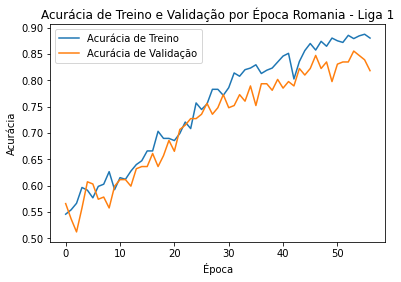

Treinando modelo para a liga: Netherlands - Eredivisie
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
26/26 [==============================] - 1s 9ms/step - loss: 0.7783 - accuracy: 0.5224 - val_loss: 0.6822 - val_accuracy: 0.5732 - lr: 0.0021
Epoch 2/300
26/26 [==============================] - 0s 4ms/step - loss: 0.6994 - accuracy: 0.5473 - val_loss: 0.6797 - val_accuracy: 0.5707 - lr: 0.0021
Epoch 3/300
26/26 [==============================] - 0s 4ms/step - loss: 0.6856 - accuracy: 0.5522 - val_loss: 0.6756 - val_accuracy: 0.5658 - lr: 0.0021
Epoch 4/300
26/26 [==============================] - 0s 4ms/step - loss: 0.6851 - accuracy: 0.5728 - val_loss: 0.6704 - val_accuracy: 0.5856 - lr: 0.0021
Epoch 5/300
26/26 [==============================] - 0s 4ms/step - loss: 0.6862 - accuracy: 0.5808 - val_loss: 0.6838 - val_accuracy: 0.5757 - lr: 0.0021
Epoch 6/300
26/26 [======

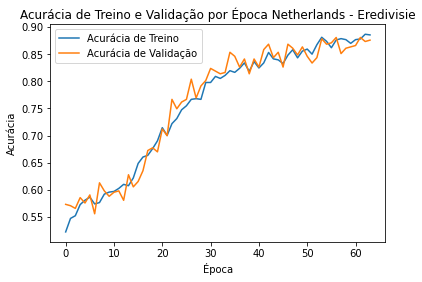

Treinando modelo para a liga: Europe - UEFA Nations League
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
24/24 [==============================] - 1s 11ms/step - loss: 0.8576 - accuracy: 0.5099 - val_loss: 0.6916 - val_accuracy: 0.5816 - lr: 0.0043
Epoch 2/300
24/24 [==============================] - 0s 5ms/step - loss: 0.7138 - accuracy: 0.5303 - val_loss: 0.6798 - val_accuracy: 0.5737 - lr: 0.0043
Epoch 3/300
24/24 [==============================] - 0s 5ms/step - loss: 0.7033 - accuracy: 0.5547 - val_loss: 0.6721 - val_accuracy: 0.5974 - lr: 0.0043
Epoch 4/300
24/24 [==============================] - 0s 5ms/step - loss: 0.6871 - accuracy: 0.5685 - val_loss: 0.6597 - val_accuracy: 0.6026 - lr: 0.0043
Epoch 5/300
24/24 [==============================] - 0s 5ms/step - loss: 0.6627 - accuracy: 0.6061 - val_loss: 0.6512 - val_accuracy: 0.6395 - lr: 0.0043
Epoch 6/300
24/24 [=

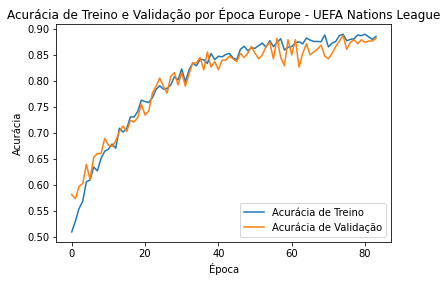

Treinando modelo para a liga: Italy - Serie A
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
43/43 [==============================] - 1s 7ms/step - loss: 0.9077 - accuracy: 0.4950 - val_loss: 0.7700 - val_accuracy: 0.4720 - lr: 0.0011
Epoch 2/300
43/43 [==============================] - 0s 4ms/step - loss: 0.7740 - accuracy: 0.5135 - val_loss: 0.7402 - val_accuracy: 0.5605 - lr: 0.0011
Epoch 3/300
43/43 [==============================] - 0s 3ms/step - loss: 0.7579 - accuracy: 0.5090 - val_loss: 0.7370 - val_accuracy: 0.5811 - lr: 0.0011
Epoch 4/300
43/43 [==============================] - 0s 3ms/step - loss: 0.7477 - accuracy: 0.5113 - val_loss: 0.7365 - val_accuracy: 0.5693 - lr: 0.0011
Epoch 5/300
43/43 [==============================] - 0s 3ms/step - loss: 0.7484 - accuracy: 0.4921 - val_loss: 0.7366 - val_accuracy: 0.5310 - lr: 0.0011
Epoch 6/300
43/43 [===============

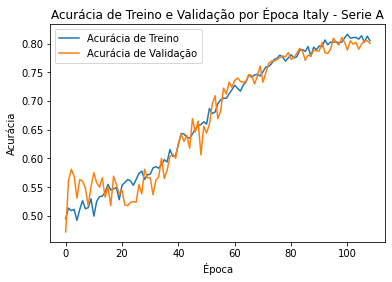

Treinando modelo para a liga: Brazil - Paulista A1
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
19/19 [==============================] - 1s 12ms/step - loss: 1.0553 - accuracy: 0.4992 - val_loss: 0.7424 - val_accuracy: 0.5151 - lr: 8.6215e-04
Epoch 2/300
19/19 [==============================] - 0s 5ms/step - loss: 0.8222 - accuracy: 0.5034 - val_loss: 0.7519 - val_accuracy: 0.4716 - lr: 8.6215e-04
Epoch 3/300
19/19 [==============================] - 0s 5ms/step - loss: 0.7939 - accuracy: 0.5218 - val_loss: 0.7434 - val_accuracy: 0.4515 - lr: 8.6215e-04
Epoch 4/300
19/19 [==============================] - 0s 5ms/step - loss: 0.7735 - accuracy: 0.5000 - val_loss: 0.7452 - val_accuracy: 0.4381 - lr: 8.6215e-04
Epoch 5/300
19/19 [==============================] - 0s 5ms/step - loss: 0.7576 - accuracy: 0.5042 - val_loss: 0.7406 - val_accuracy: 0.4916 - lr: 8.6215e-04
Epoch 6/

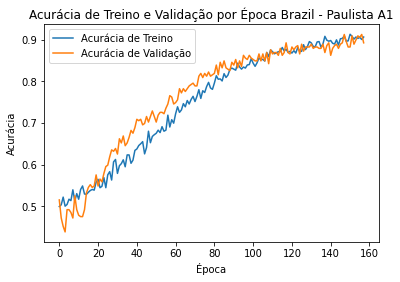

Treinando modelo para a liga: Japan - J-League
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
31/31 [==============================] - 1s 8ms/step - loss: 0.8455 - accuracy: 0.4948 - val_loss: 0.7075 - val_accuracy: 0.5590 - lr: 0.0025
Epoch 2/300
31/31 [==============================] - 0s 4ms/step - loss: 0.7254 - accuracy: 0.5394 - val_loss: 0.7085 - val_accuracy: 0.5528 - lr: 0.0025
Epoch 3/300
31/31 [==============================] - 0s 3ms/step - loss: 0.7066 - accuracy: 0.5648 - val_loss: 0.7110 - val_accuracy: 0.5280 - lr: 0.0025
Epoch 4/300
31/31 [==============================] - 0s 3ms/step - loss: 0.7053 - accuracy: 0.5492 - val_loss: 0.6972 - val_accuracy: 0.5776 - lr: 0.0025
Epoch 5/300
31/31 [==============================] - 0s 3ms/step - loss: 0.7090 - accuracy: 0.5383 - val_loss: 0.7060 - val_accuracy: 0.5404 - lr: 0.0025
Epoch 6/300
31/31 [==============

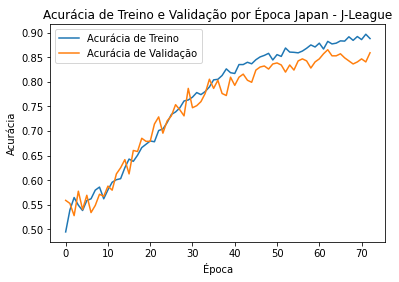

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold
from keras.metrics import Precision, Recall
from keras.regularizers import l1_l2
from keras.regularizers import l2
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
import tensorflow as tf
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasClassifier
from scipy.stats import loguniform

# Função para criar o modelo Keras com as novas sugestões aplicadas
def create_model(learning_rate=0.001, l2_rate=0.0001, dropout_rate=0.4):
    model = Sequential()
    model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(l2_rate)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(l2_rate)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(l2_rate)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    # Use a learning rate schedule
    initial_learning_rate = learning_rate
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True)
    optimizer = Adam(learning_rate=lr_schedule)
    
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

for league in df['league'].unique():
    print(f"Treinando modelo para a liga: {league}")
    
    # Filtrando o conjunto de dados para apenas a liga atual

    league_data = df[df['league'] == league]

    # Preparando os dados de entrada e saída
    X = league_data.drop(['result', 'league', 'homeTeam', 'awayTeam', 'match_id'], axis=1)
    y = league_data['result'].values  # Garantindo que y é um array numpy

    # Criando e ajustando o preprocessador
    preprocessor = create_preprocessor(X)
    X_transformed = preprocessor.transform(X)
    print("Dados transformados pelo preprocessador.")

    X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.20, random_state=42)
    print("Dados divididos em conjuntos de treino e teste.")

    # Callback de EarlyStopping
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

    # Callback de ReduceLROnPlateau
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5, verbose=1)

    # Ajustando os hiperparâmetros para a pesquisa
    param_dist = {
        'learning_rate': loguniform(1e-4, 1e-2).rvs(1000),  # Exploring a wider range of learning rates
        'l2_rate': loguniform(1e-5, 1e-3).rvs(1000),        # Adjusting L2 regularization rate
        'dropout_rate': [0.3, 0.4, 0.5]                     # Testing different dropout rates
    }

    model = KerasClassifier(build_fn=create_model, epochs=300, callbacks=[early_stop, reduce_lr], batch_size=64, verbose=1, learning_rate=param_dist['l2_rate'], l2_rate=param_dist['l2_rate'], dropout_rate=param_dist['dropout_rate'])
    # Criando o RandomizedSearchCV com a nova distribuição de hiperparâmetros
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=10,
        cv=3,
        verbose=2,
        random_state=42,
        n_jobs=-1
    )

    # Executando a pesquisa aleatória
    random_search_results = random_search.fit(
        X_train,
        y_train,
        callbacks=[early_stop, reduce_lr],
        validation_data=(X_test, y_test)  
    )

    # Imprimindo os melhores resultados
    print("Best: %f using %s" % (random_search_results.best_score_, random_search_results.best_params_))

    # Plote as métricas de treino e validação com o melhor modelo
    best_model = random_search_results.best_estimator_

    # Prever as probabilidades para o conjunto de teste
    y_probs = best_model.predict(X_test)
    class_names = ['Classe 0', 'Classe 1']
    # Imprimir o relatório de classificação
    print(classification_report(y_test, y_probs, target_names=class_names))

    plt.plot(best_model.history_['accuracy'], label='Acurácia de Treino')
    plt.plot(best_model.history_['val_accuracy'], label='Acurácia de Validação')
    plt.title(f'Acurácia de Treino e Validação por Época {league}')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()
    plt.show()

    best_model.model_.save(f'../models/model_redeht_{league}.h5')

In [ ]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# # Prever as probabilidades para o conjunto de teste
# y_probs = model.predict(X_test)

# # Inicialize o valor do threshold que você quer testar, por exemplo:
# thresholds = np.arange(0.1, 0.9, 0.1)

# # Para cada threshold, calcule e imprima as métricas
# for thresh in thresholds:
#     # Converta probabilidades em previsões binárias com base no threshold
#     y_pred = (y_probs >= thresh).astype(int)
    
#     # Calcule as métricas
#     precision = precision_score(y_test, y_pred)
#     recall = recall_score(y_test, y_pred)
#     f1 = f1_score(y_test, y_pred)
#     accuracy = accuracy_score(y_test, y_pred)
    
#     # Imprima as métricas
#     print(f'Threshold: {thresh:.2f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1 Score: {f1:.3f}, Accuracy: {accuracy:.3f}')

# # Escolha o threshold que oferece o melhor equilíbrio entre as métricas que são importantes para o seu caso de uso
